### Análisis de Datos - CEIA 2Co2021, FIUBA
# RainTomorrow: predición de precipitaciones en Australia

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQATNC-EBwF-LIbDVv_L0gkP2V6oKQzah5GRg&usqp=CAU"/>

Se propone realizar el ciclo completo del desarrollo de un modelo de aprendizaje automático supervisado a partir de un [dataset de Kaggle con datos de por distintas estaciones metereológicas de Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv). El objetivo es predecir si lloverá o no al día siguiente (variable *RainTomorrow*), en función de los datos metereológicos del día actual.

### 1. Análisis exploratorio

- Descarga del [dataset de kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package?select=weatherAUS.csv)
- Descripción de las [variables]()



El dataset **weatherAUS.csv** contiene 23 columnas con 145.460 registros (samples u observaciones). 
- Cada registro representa un día entre el 2007-11-01 y el 2017-06-25 según locación.
- Se desconoce si todas las estaciones meteorológicas se encuentran calibradas para garantizar uniformidad de medición. 
- Variables por tipo de dato (las variables creadas para este análisis se presentan en *itálica*):
    * Datetime
        * Date (después de transformaciones)
    * Categóricas (las originales son strings)
        * Multiclass
            * Location: nombre convencional de la localidad en la cual se emplaza la estación meteorológica que realiza la medición/provee la información. 
            * WindGustDir, WindDir9am, WindDir3pm: dirección hacia donde sopla el viento (la ráfaga más fuerte y justo antes de los horarios de medición habitual), 16 categorías asociadas a la rosa de los vientos.
            * *Month* (numérica), cada número representa un mes según la secuencia del calendario.
            * *Region*, se construye para agrupar locaciones que representen áreas reconocidas según las principales regiones australianas, son 10 aunque se presentan 9 en el dataset (no hay registros de la Antártida)
        * Dicotómicas o binaria
            * *RainToday*, construcción sobre lo que se considera lluvia: YES si es mayor a 1mm (boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0)
            * *RainTomorrow*,output o variable de resultado de la predicción
            * *DrySeason y DrySeasonExtended* (dummies) son construcciones basadas en las estaciones más marcadas del año en lo que a lluvias respecta.
            * *RainyDay* (dummy), construcción para verificar RainToday  
        * Ordinales
            * Cloud9am y Cloud3pm (numérica) intensidad de nubosidad, del 1 al 9 en escala creciente, solo hasta 8 en el dataset 
            * *DayYear* (numérica), representa el número de orden de la secuencia del calendario
        * Numéricas (las 14 originales, float)
            * MinTemp y MaxTemp corresponden a las cotas de temperatura en grados celsius según el rango identificado para cada día. 
            * Se realizan 2 mediciones sistemáticas de las condiciones ambientales en el día (9am y 3pm o justo antes de esas horas en lo que refiere a viento): velocidad del viento, humedad, presión y temperatura (variables homónimas en inglés seguidas del horario de medición). Al las mediciones de viento se suma WindGustSpeed (ráfaga de mayor velocidad).
            * Rainfall (mm), Evaporation (mm), Sunshine (hs de claridad) dan cuenta del día.
            * *Year*.

*RainToday* y *RainTomorrow* fueron convertidas a dummies 0/1, siendo 1 la presencia del evento al que refieren. Lógica análoga sigue *RainyDay* que contempla los reajustes de RainToday tras la limpieza de datos.

#### Aproximación al dataset

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
#df.info()

In [4]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


#### Exploración inicial e identificación de contenido relevante

Se priorizan las variables relativas a precipitaciones, espacio temporal, verificación de categorías construidas, detección de regiones geográficas y su posible asociación climática.
Se realizan distintos análisis descriptivos y gráficos para caracterizar los datos, generar nueva información y explorar posibles agrupamientos que faciliten la posterior toma de decisiones, etc.

Se destaca que el trabajo de feature engineering, extracción de información y codificación o retipificación de variables se hace, en gran medida, integrado al proceso de exploración aquí presentado.

In [5]:
#en ciertos casos se prsenta código comentado que fuera de utilidad paraa comprender los datos y proceder con algun nuevo paso en la exploración pero se su visualización o aporte no es el más prioritario para la corrida final 
#for i in df.columns:
#    print(df[i].value_counts())

In [6]:
df['Date'].sort_values(ascending=True).head(5)

45587    2007-11-01
45588    2007-11-02
45589    2007-11-03
45590    2007-11-04
45591    2007-11-05
Name: Date, dtype: object

In [7]:
df['Date'].sort_values(ascending=True).tail(5)

64190     2017-06-25
67199     2017-06-25
70392     2017-06-25
123830    2017-06-25
145459    2017-06-25
Name: Date, dtype: object

In [8]:
# reformateo y nuevas variables
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['DayYear'] = pd.DatetimeIndex(df['Date']).dayofyear

In [9]:
# nuevas variables...
# las estaciones no parecen tan marcadas como la época de lluvias
# a la hora de crear la variable...  hay distintas versión del período, cambia según fuente
df['DrySeason'] = 0
df.loc[(df['Month']>=6) & (df['Month']<=10), 'DrySeason'] = 1

df['DrySeasonExt'] = 0 
df.loc[(df['Month']>=5) & (df['Month']<=11), 'DrySeasonExt'] = 1

La estación seca no es tan notoria en el calendario. Sin embargo, ciertos años se observa mayor caudal de precipitaciones (2010 y 2012, aunque este último con una menor intensidad) mientras que dicho incremento no resulta sustantivo en otros o se presenta cierta escasez de lluvias. Dicha volatilidad es confirmada en http://www.bom.gov.au/climate/history/rainfall/. Se registran valores atípicos para los primeros meses de 2011 y 2013.

Asimismo, la distribución de las precpitaciones durante los primeros días de febrero se puede observar a continuación.
<img src='https://cdn.newsapi.com.au/image/v1/36961c271817b2a9ccd9b15850729bf0?width=650'/>

#### Ploteo anual de precipitaciones 
Información del 01/11/2007 al 25/05/2017

<Figure size 864x216 with 0 Axes>

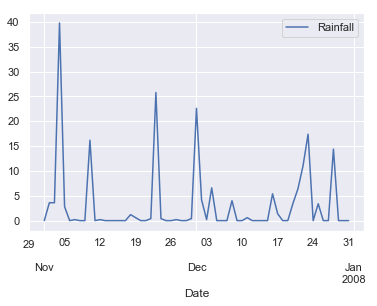

In [10]:
plt.figure(figsize=(12, 3));
df.loc[df['Year']==2007, :].plot(x='Date', y='Rainfall');

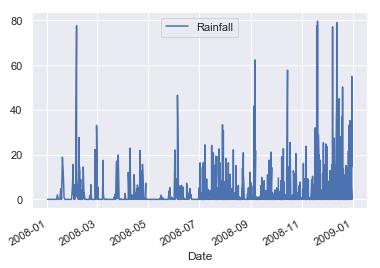

In [11]:
df.loc[df['Year']==2008, :].plot(x='Date', y='Rainfall');

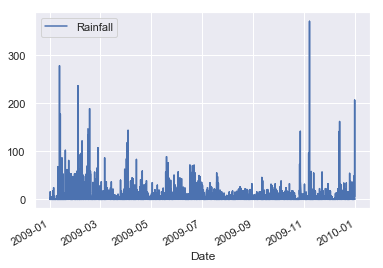

In [12]:
df.loc[df['Year']==2009, :].plot(x='Date', y='Rainfall');

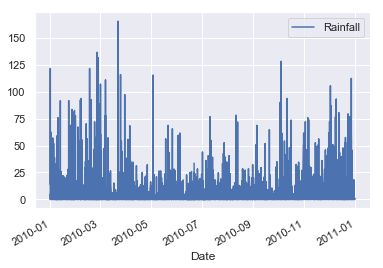

In [13]:
df.loc[df['Year']==2010, :].plot(x='Date', y='Rainfall');

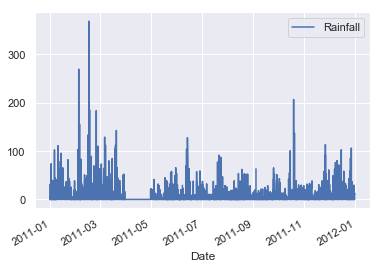

In [14]:
df.loc[df['Year']==2011, :].plot(x='Date', y='Rainfall');

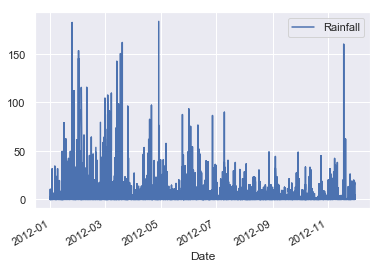

In [15]:
df.loc[df['Year']==2012, :].plot(x='Date', y='Rainfall');

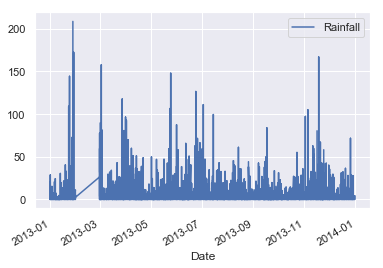

In [16]:
df.loc[df['Year']==2013, :].plot(x='Date', y='Rainfall');

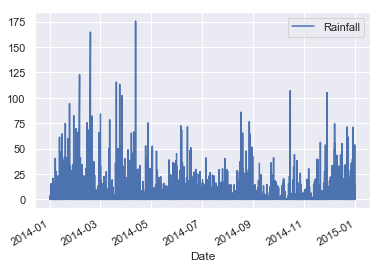

In [17]:
df.loc[df['Year']==2014, :].plot(x='Date', y='Rainfall');

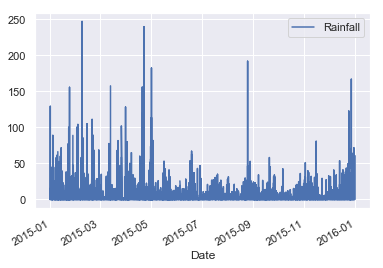

In [18]:
df.loc[df['Year']==2015, :].plot(x='Date', y='Rainfall');

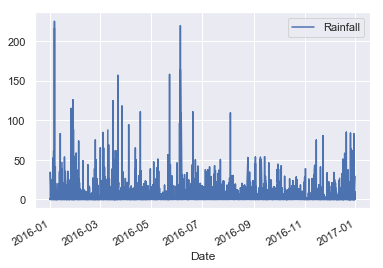

In [19]:
df.loc[df['Year']==2016, :].plot(x='Date', y='Rainfall');

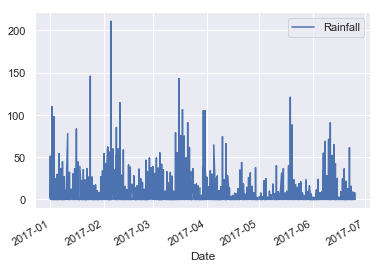

In [20]:
df.loc[df['Year']==2017, :].plot(x='Date', y='Rainfall');

#### Exploración inicial e identificación de contenido relevante (ii)

In [21]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Year', 'Month', 'DayYear',
       'DrySeason', 'DrySeasonExt'],
      dtype='object')

In [22]:
# agrupamientos para manipulación de datos
date = ['Date']

categ = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 
         'RainToday', 'RainTomorrow', 'Region']

numericas_discr = ['Cloud9am', 'Cloud3pm'] #estrictamente categórica ordinal, pero para plotearla no demanda transformaciones

numericas_cont = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                  'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                  'Pressure9am', 'Pressure3pm', 'Temp9am','Temp3pm']

numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
             'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
             'Pressure9am', 'Pressure3pm', 'Temp9am','Temp3pm', 'Cloud9am', 'Cloud3pm']

num_1 = ['MinTemp', 'MaxTemp', 'Temp9am','Temp3pm']
num_2 = ['Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
num_3 = ['Rainfall', 'Evaporation', 'Humidity9am', 'Humidity3pm']
num_4 = ['Cloud9am', 'Cloud3pm','Pressure9am', 'Pressure3pm']

In [23]:
#for i in categ:
#    print(df[i].value_counts(dropna=False))

<img src="https://www.touropia.com/gfx/b/2019/07/australia.png"/>

In [24]:
# nueva variable para regionalizar áreas
# adaptación basada en http://www.bom.gov.au/climate/dwo/
df['Region'] = None

df.loc[(df['Location']=='Canberra') | (df['Location']=='Tuggeranong'), 'Region'] = 'ACT' # Capital Territory

df.loc[(df['Location']=='Sydney') | (df['Location']=='Penrith') | (df['Location']=='Newcastle') 
       | (df['Location']=='Wollongong') 
       | (df['Location']=='SydneyAirport') |(df['Location']=='BadgerysCreek') | (df['Location']=='Cobar') 
       | (df['Location']=='CoffsHarbour') | (df['Location']=='Moree') | (df['Location']=='NorahHead') 
       | (df['Location']=='WaggaWagga') | (df['Location']=='Williamtown') | (df['Location']=='MountGinini'), 
       'Region'] = 'NewSouthWales'
    
df.loc[(df['Location']=='Melbourne') | (df['Location']=='Ballarat') | (df['Location']=='Albury') 
       | (df['Location']=='Bendigo') 
       | (df['Location']=='MelbourneAirport') | (df['Location']=='Richmond') | (df['Location']=='Sale') 
       | (df['Location']=='Mildura') | (df['Location']=='Nhil') | (df['Location']=='Portland') 
       | (df['Location']=='Watsonia') | (df['Location']=='Dartmoor'), 'Region'] = 'Victoria'

df.loc[(df['Location']=='Brisbane') | (df['Location']=='Cairns') | (df['Location']=='Townsville') 
       | (df['Location']=='GoldCoast'), 'Region'] = 'Queensland'

df.loc[(df['Location']=='Adelaide') | (df['Location']=='MountGambier') | (df['Location']=='Renmark') 
       | (df['Location']=='Port Lincoln') | (df['Location']=='Nuriootpa'), 'Region'] = 'South'

df.loc[ (df['Location']=='Perth') | (df['Location']=='Albany') | (df['Location']=='Kalgoorlie-Boulder') 
       | (df['Location']=='Broome') | (df['Location']=='PerthAirport') 
       | (df['Location']=='Walpole') | (df['Location']=='SalmonGums') | (df['Location']=='Woomera') 
       | (df['Location']=='Witchcliffe') | (df['Location']=='PearceRAAF'), 'Region'] = 'Western'

df.loc[(df['Location']=='Hobart') | (df['Location']=='Launceston') | (df['Location']=='Wynyard') 
       | (df['Location']=='Devonport'), 'Region'] = 'Tasmania'

df.loc[(df['Location']=='Darwin') | (df['Location']=='AliceSprings') | (df['Location']=='Katherine') 
       | (df['Location']=='Tennant Creek') | (df['Location']=='Uluru'), 'Region'] = 'Northern'

df.loc[(df['Location']=='Casey') | (df['Location']=='Davis') | (df['Location']=='Mawson') 
       | (df['Location']=='Macquarie Island'), 'Region'] = 'Antarctic Bases' ## sin datos

df.loc[(df['Location']=='Christmas') | (df['Location']=='Cocos') | (df['Location']=='NorfolkIsland') 
       | (df['Location']=='Lord Howe Islands'), 'Region'] = 'OffshoreIslands'

In [25]:
# 9 regiones con datos (no se incluyen datos sobre las bases antárticas)
df['Region'].value_counts(dropna=False)

NewSouthWales      39569
Victoria           34954
Western            24276
Queensland         12313
Northern            9389
South               9242
ACT                 6475
Tasmania            6233
OffshoreIslands     3009
Name: Region, dtype: int64

In [26]:
#df.loc[df['Region']-isnull(), 'Location'].value_counts()
#df.loc[df['Region'].isnull(), 'Location'].unique()
#df['Location'].value_counts(dropna=False)
#df[df['Region'].isnull()]

#### Ploteo de precipitación por regiones

La red de observación fue incorporando nuevas estaciones a lo largo del tiempo: Canberra y Sydney reportan desde el inicio de la serie, a fines de 2008 se incorporaron 6 ciudades, a principios de 2009 se incorporó la mayoría y las últimas 3, en 2013 (de allí las disparidades en las frecuencias). 

Los valores atípicos superan los 80 y los 100mm, alcanzando extremos de 200 y 300mm (New South Wales en 2010). La mayor estacionalidad se observa en las zonas de Western, Queensland y Northern.

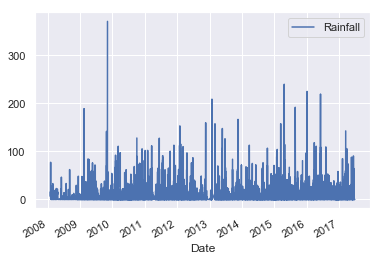

In [27]:
df.loc[df['Region']=='NewSouthWales', :].plot(x='Date', y='Rainfall');

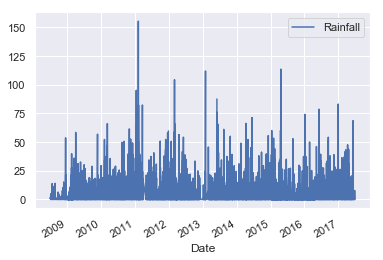

In [28]:
df.loc[df['Region']=='Victoria', :].plot(x='Date', y='Rainfall');

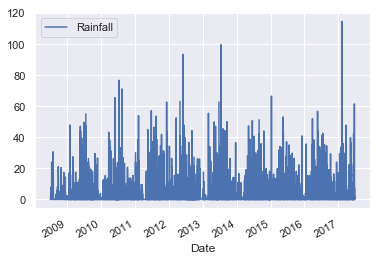

In [29]:
df.loc[df['Region']=='Western', :].plot(x='Date', y='Rainfall');

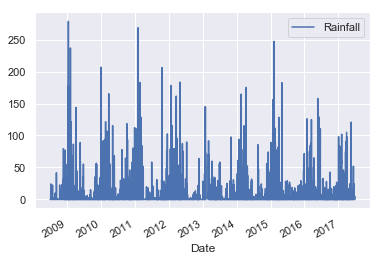

In [30]:
df.loc[df['Region']=='Queensland', :].plot(x='Date', y='Rainfall');

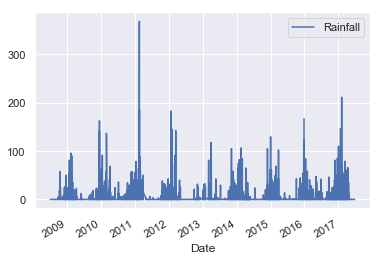

In [31]:
df.loc[df['Region']=='Northern', :].plot(x='Date', y='Rainfall');
# nueva info o emas? no en 2007  y 2008

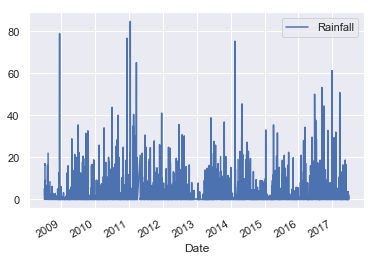

In [32]:
df.loc[df['Region']=='South', :].plot(x='Date', y='Rainfall');
# nueva info o emas? no en 2007  y 2008

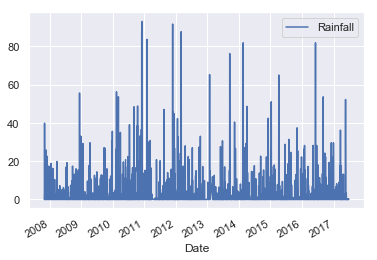

In [33]:
df.loc[df['Region']=='ACT', :].plot(x='Date', y='Rainfall');

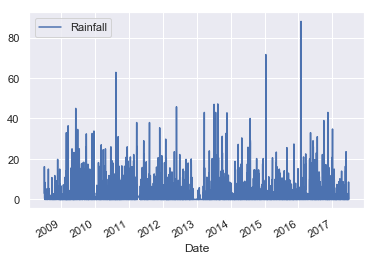

In [34]:
df.loc[df['Region']=='Tasmania', :].plot(x='Date', y='Rainfall');
# nueva info o emas? no en 2007  y 2008

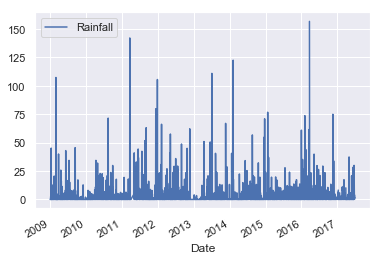

In [35]:
df.loc[df['Region']=='OffshoreIslands', :].plot(x='Date', y='Rainfall');
# nueva info o emas? no en 2007  y 2008

#### Exploración inicial e identificación de contenido relevante (iii)

In [36]:
#df.loc[((df['Year']==2011)&(df['Month']==4))|((df['Year']==2011)&(df['Month']==5)),
#       ['Region', 'Rainfall', 'RainToday']].sample(10)

In [37]:
#df.loc[((df['Year']==2011)|(df['Year']==2013))&((df['Month']==3)|
#       (df['Month']==4)|(df['Month']==5)),['Region', 'Rainfall', 'RainToday']].sample(10)

In [38]:
# nueva variable, para verificacion
df['RainyDay'] = np.nan

# según agencia australiana
# boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0
df.loc[df['Rainfall']>1, 'RainyDay'] = 1
df.loc[df['Rainfall']<=1, 'RainyDay'] = 0

In [39]:
df['RainyDay'].sum() 
# si incluye =1 => 33639
# si no incluye =1 => 31880

31880.0

In [40]:
df['RainToday'].value_counts() 

No     110319
Yes     31880
Name: RainToday, dtype: int64

Coincidencia en totales. Se generan subsets por condiciones para corroborarlo.

In [41]:
#df.loc[(df['RainyDay']==1) & (df['RainToday']=='Yes'),:].shape

In [42]:
#df.loc[(df['RainyDay']==0) & (df['RainToday']=='No'),:].shape

In [43]:
#df.loc[(df['RainyDay']==0) & (df['RainToday']=='Yes'),:].shape

In [44]:
#df.loc[(df['RainyDay']==1) & (df['RainToday']=='No'),:].shape

¿Qué sucede entonces con el prónostico de precipitaciones para el día siguiente?

In [45]:
#df.loc[(df['RainTomorrow']=='Yes') & (df['RainToday']=='Yes'),:].shape

In [46]:
#df.loc[(df['RainTomorrow']=='Yes') & (df['RainToday']=='No'),:].shape

In [47]:
#df.loc[(df['RainTomorrow']=='No') & (df['RainToday']=='Yes'),:].shape

In [48]:
#df.loc[(df['RainTomorrow']=='No') & (df['RainToday']=='No'),:].shape

In [49]:
a = 14597 
b = 16604
c = a + b
print(c) # casos identificados 31880
a/c 
# => podría decirse que de cada dos días con precipitaciones, 
#cerca de la mitad (1) no llueve al días siguiente

31201


0.467837569308676

In [50]:
print(df['RainToday'].value_counts(normalize=True, dropna=False)*100)
print(df['RainTomorrow'].value_counts(normalize=True, dropna=False)*100)

No     75.841468
Yes    21.916678
NaN     2.241853
Name: RainToday, dtype: float64
No     75.839406
Yes    21.914616
NaN     2.245978
Name: RainTomorrow, dtype: float64


Las clases de RainToday y RainTomorrow no están balanceadas ya que la presencia de precipitaciones se presenta en el 21,9% de los casos (además de un 2,2% de misings).

#### Ploteo de variables categóricas

In [51]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Year', 'Month', 'DayYear',
       'DrySeason', 'DrySeasonExt', 'Region', 'RainyDay'],
      dtype='object')

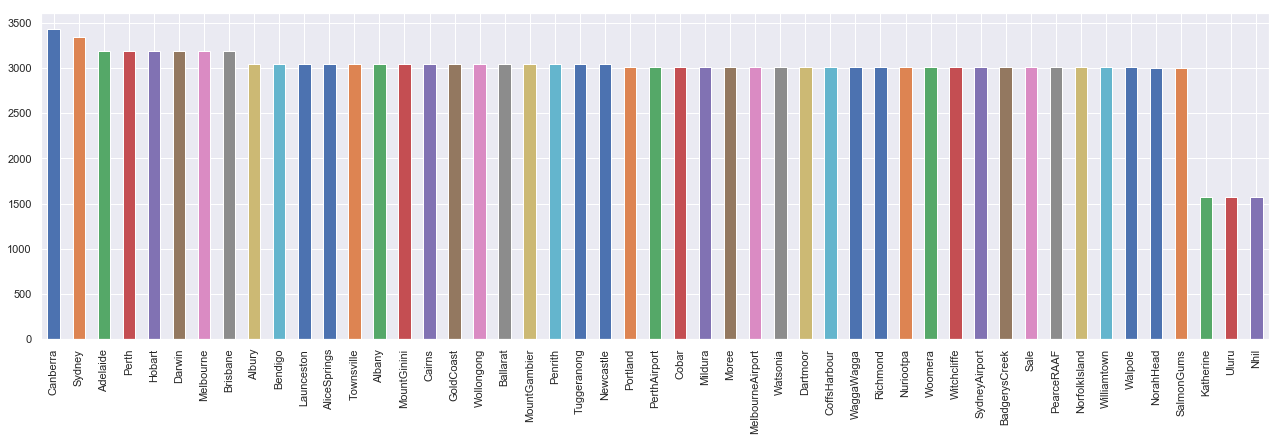

In [52]:
plt.figure(figsize=(22, 6));
df['Location'].value_counts(dropna=False).plot('bar');

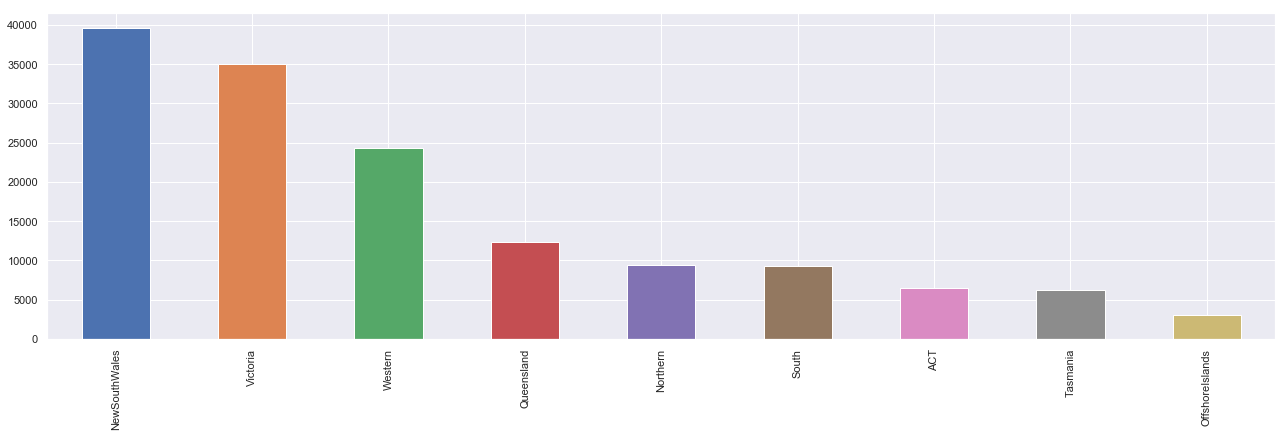

In [53]:
plt.figure(figsize=(22, 6));
df['Region'].value_counts(dropna=False).plot('bar');

No hay correspondencia (en todos los casos, entre territorio cubierto y cantidad de observaciones (por ej. Western or Northern vs NSW u otros del Este).

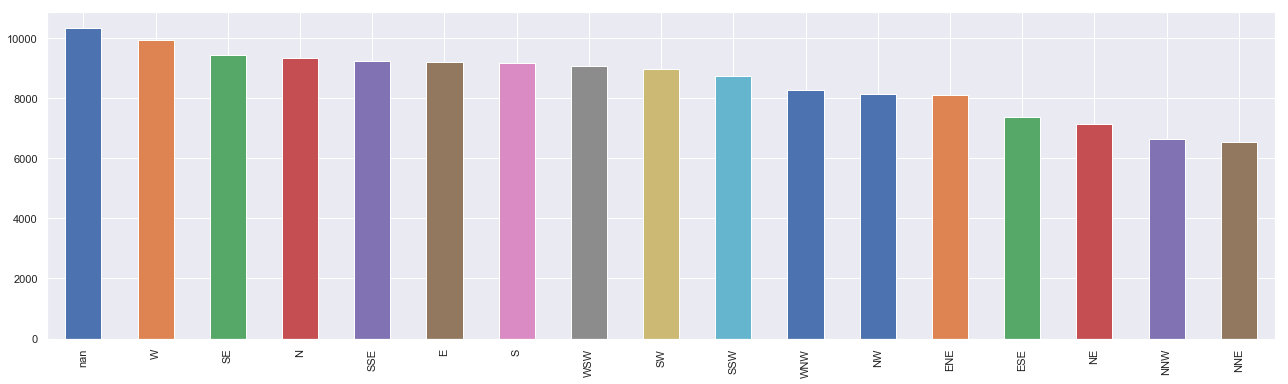

In [54]:
plt.figure(figsize=(22, 6));
df['WindGustDir'].value_counts(dropna=False).plot('bar');

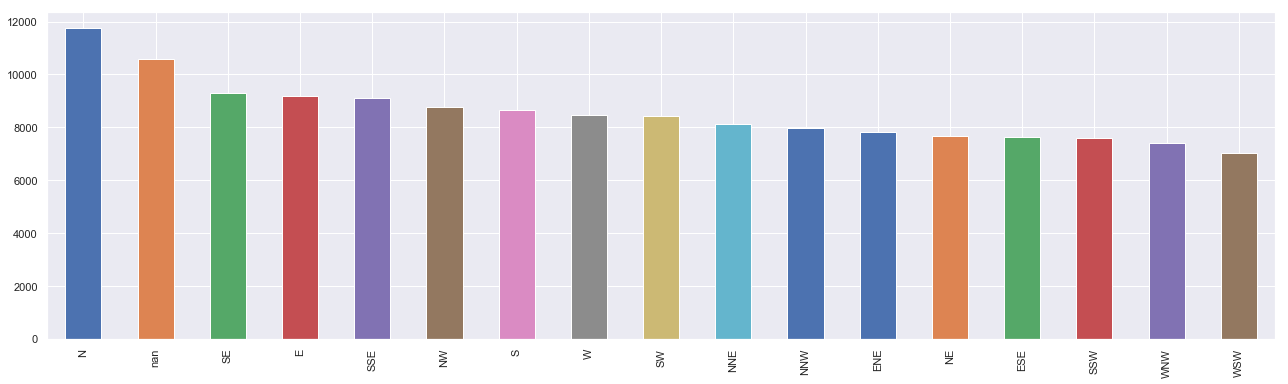

In [55]:
plt.figure(figsize=(22, 6));
df['WindDir9am'].value_counts(dropna=False).plot('bar');

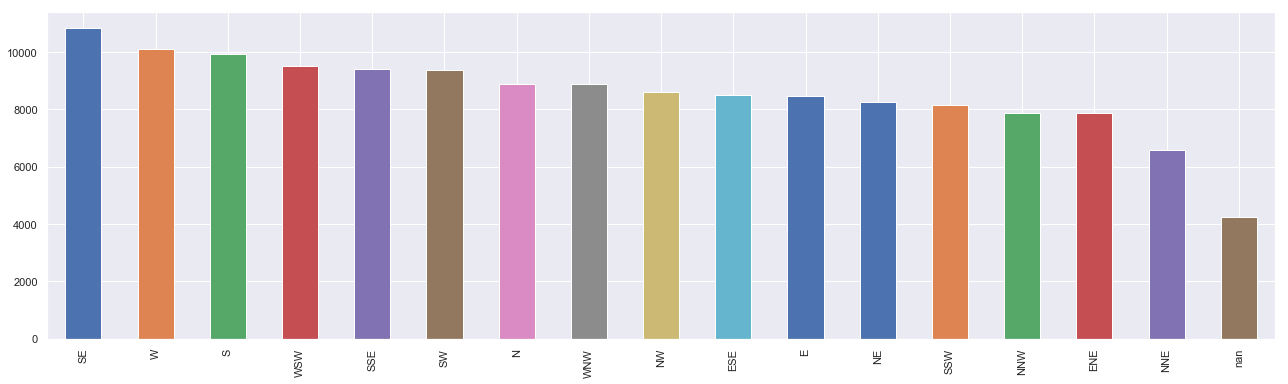

In [56]:
plt.figure(figsize=(22, 6));
df['WindDir3pm'].value_counts(dropna=False).plot('bar');

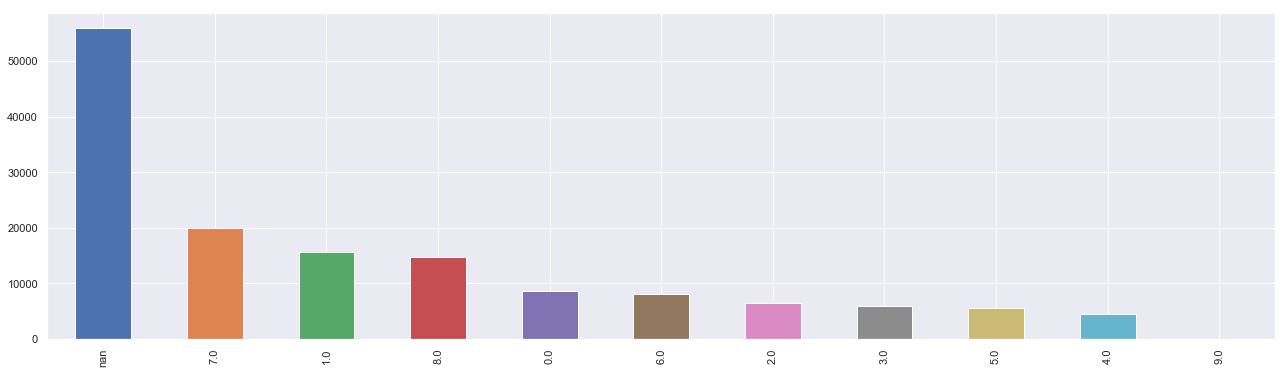

In [57]:
plt.figure(figsize=(22, 6));
df['Cloud9am'].value_counts(dropna=False).plot('bar');

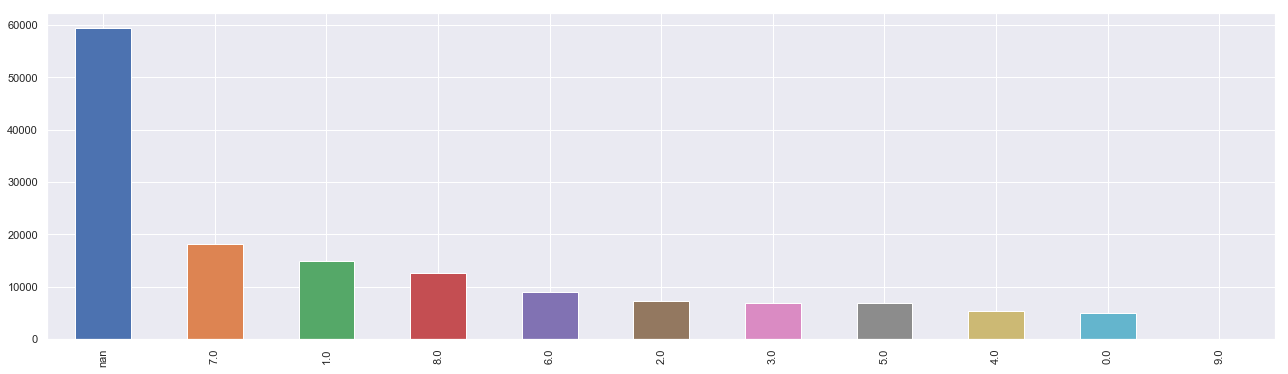

In [58]:
plt.figure(figsize=(22, 6));
df['Cloud3pm'].value_counts(dropna=False).plot('bar');

#### Distribución de precipitaciones segun regiones y variable predicha

In [59]:
# subsets de datos
df_full = df[df['RainToday'].notnull() & df['RainTomorrow'].notnull()]
df_null = df[df['RainToday'].isnull() & df['RainTomorrow'].isnull()]
df_todayNull = df[df['RainToday'].isnull() & df['RainTomorrow'].notnull()]
df_tomorrowNull = df[df['RainToday'].notnull() & df['RainTomorrow'].isnull()]

In [60]:
print(df_full.shape, df_null.shape, df_todayNull.shape, df_tomorrowNull.shape)

(140787, 30) (1855, 30) (1406, 30) (1412, 30)


In [61]:
#df.groupby('continent')['cases','deaths'].sum()

In [62]:
#plt.figure(figsize=(22, 8));
#sns.catplot(x='Region', y='Rainfall', hue='RainTomorrow', data=df_full.loc[df['RainToday']=='Yes',:], palette="Set3");

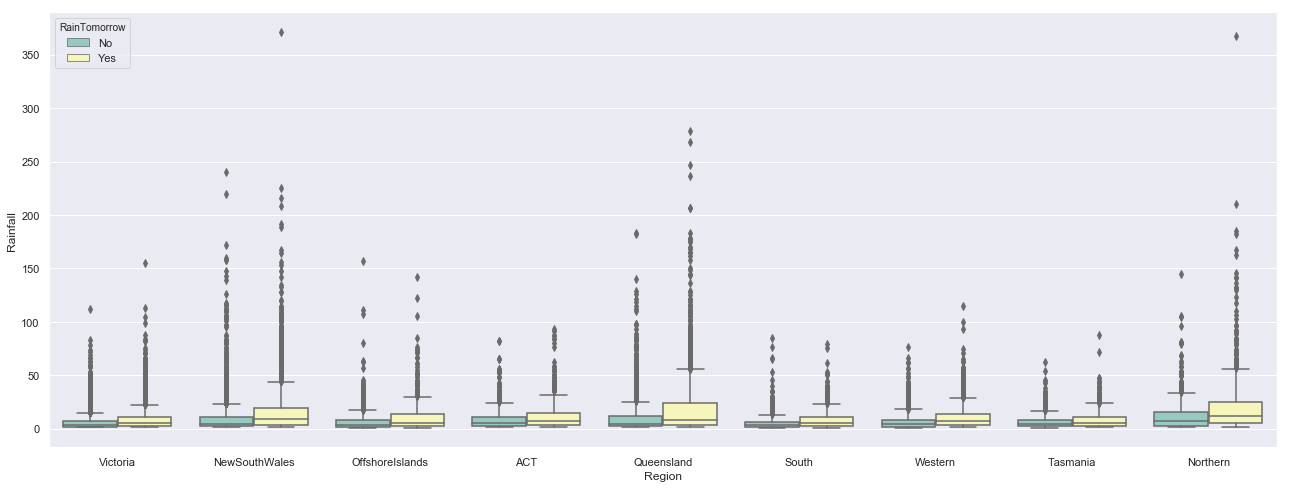

In [63]:
# distribución de predicciones si RainToday==Yes
plt.figure(figsize=(22, 8));
sns.boxplot(x='Region', y='Rainfall', hue='RainTomorrow', data=df_full.loc[df['RainToday']=='Yes',:], palette="Set3");

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


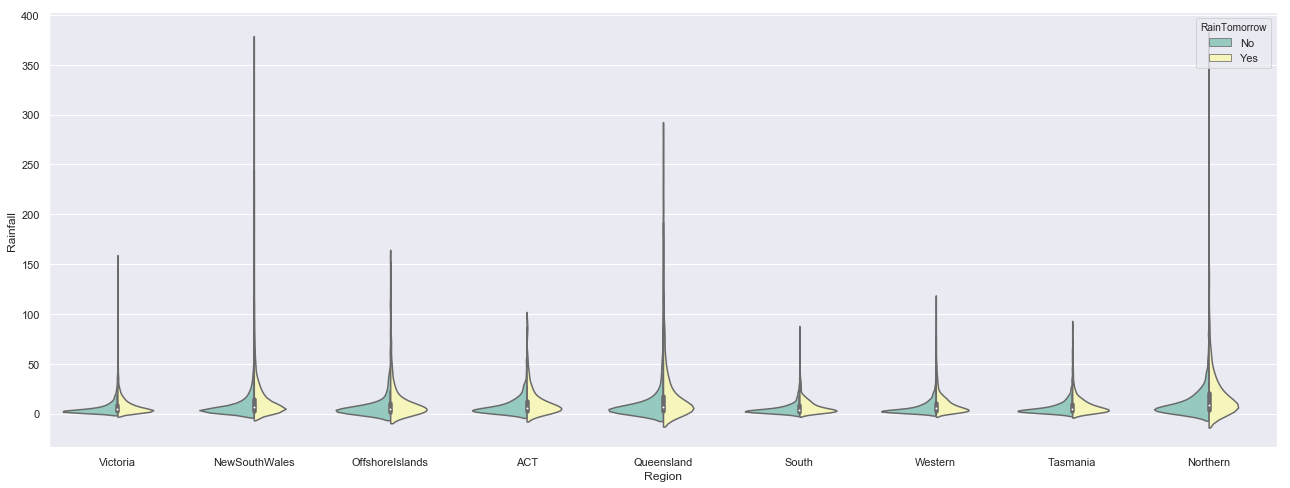

In [64]:
# distribución de predicciones si RainToday==Yes
plt.figure(figsize=(22, 8));
sns.violinplot(x='Region', y='Rainfall', hue='RainTomorrow', data=df_full.loc[df['RainToday']=='Yes',:], split=True, palette="Set3");

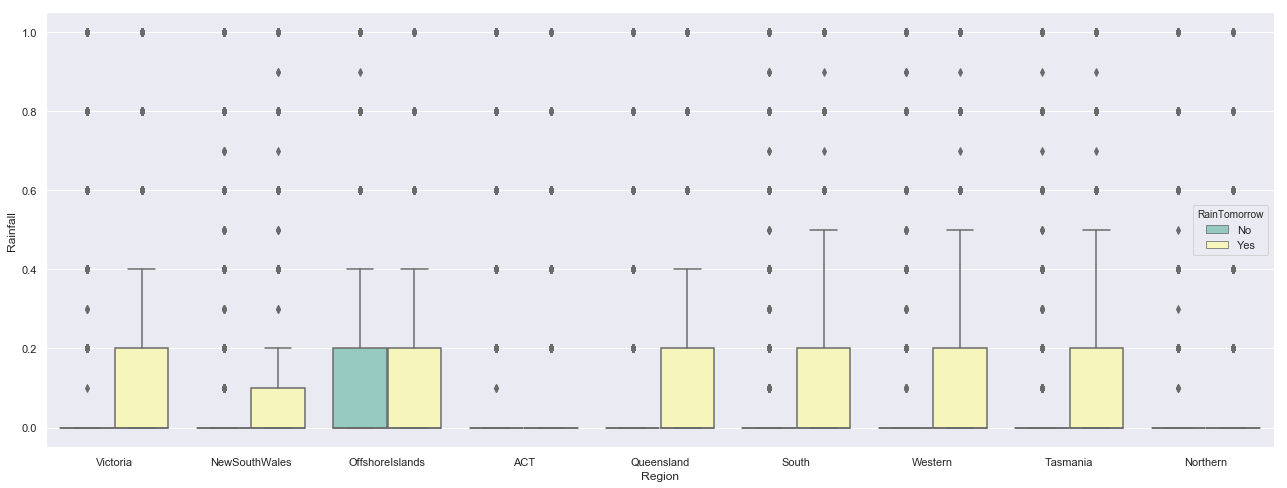

In [65]:
# distribución de predicciones si RainToday==No
plt.figure(figsize=(22, 8));
sns.boxplot(x='Region', y='Rainfall', hue='RainTomorrow', data=df_full.loc[df['RainToday']=='No',:], palette="Set3");

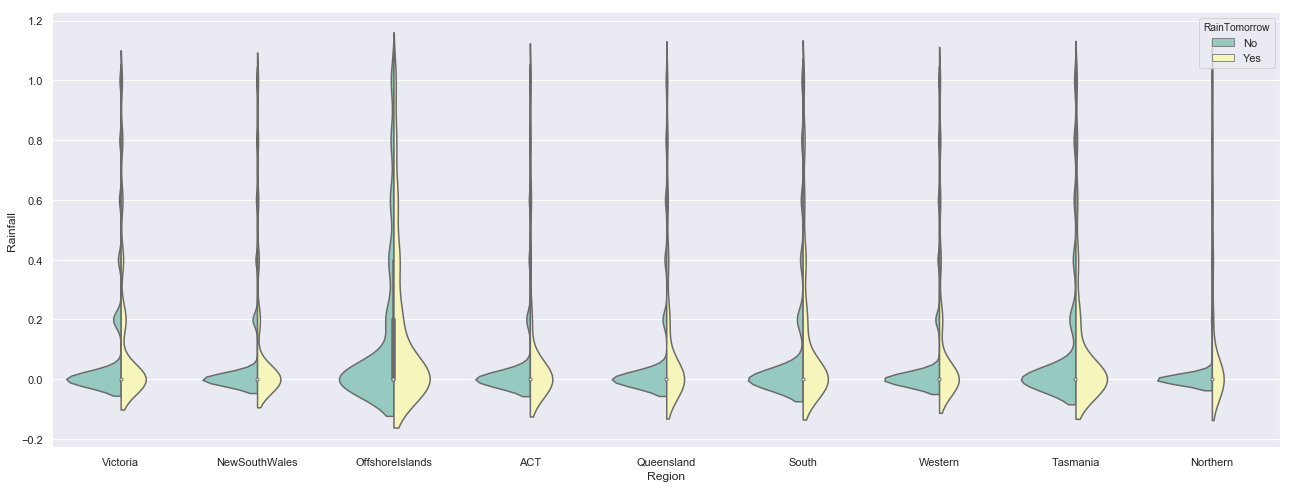

In [66]:
# distribución de predicciones si RainToday==No
plt.figure(figsize=(22, 8));
sns.violinplot(x='Region', y='Rainfall', hue='RainTomorrow', data=df_full.loc[df['RainToday']=='No',:], split=True, palette="Set3");

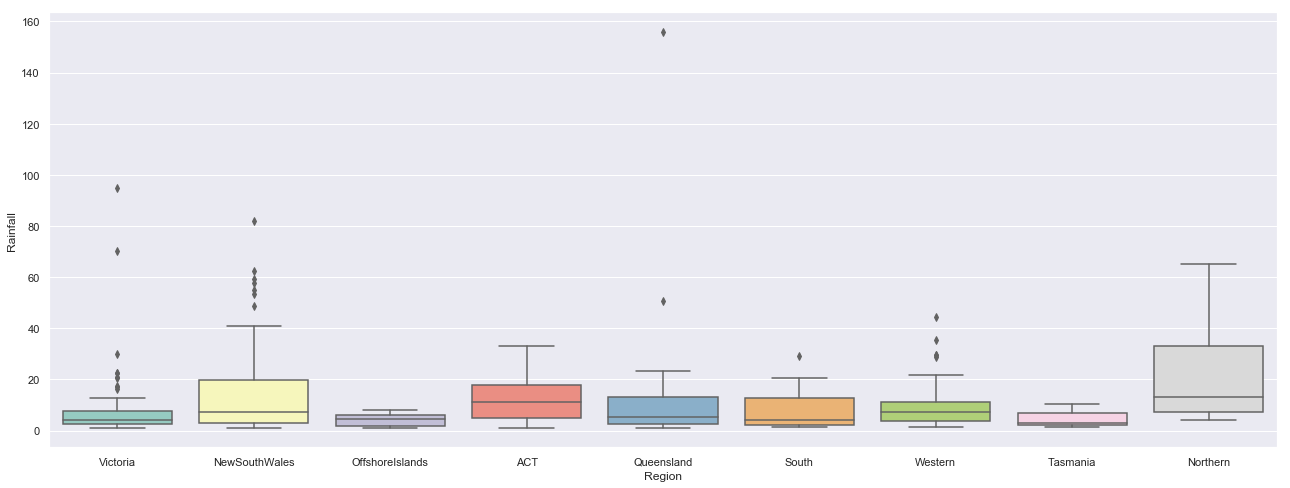

In [67]:
# distribución de predicciones si RainToday==Yes cuando no hay predicción para RainTomorrow
plt.figure(figsize=(22, 8));
sns.boxplot(x='Region', y='Rainfall', data=df_tomorrowNull.loc[df['RainToday']=='Yes',:], palette="Set3");

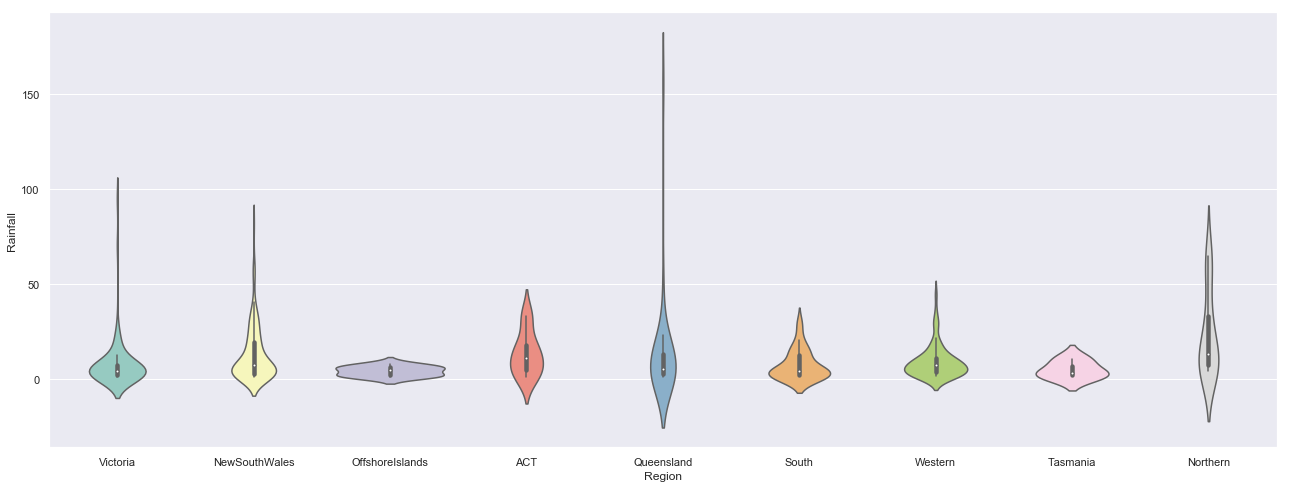

In [68]:
# distribución de predicciones si RainToday==Yes cuando no hay predicción para RainTomorrow
plt.figure(figsize=(22, 8));
sns.violinplot(x='Region', y='Rainfall', data=df_tomorrowNull.loc[df['RainToday']=='Yes',:], palette="Set3");

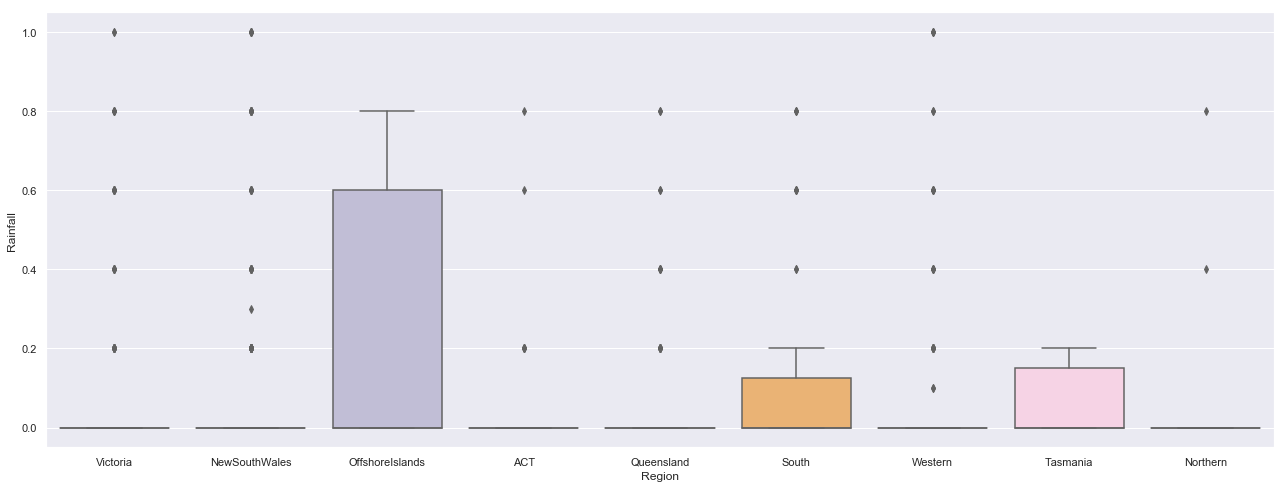

In [69]:
# distribución de predicciones si RainToday==No cuando no hay predicción para RainTomorrow
plt.figure(figsize=(22, 8));
sns.boxplot(x='Region', y='Rainfall', data=df_tomorrowNull.loc[df['RainToday']=='No',:], palette="Set3");

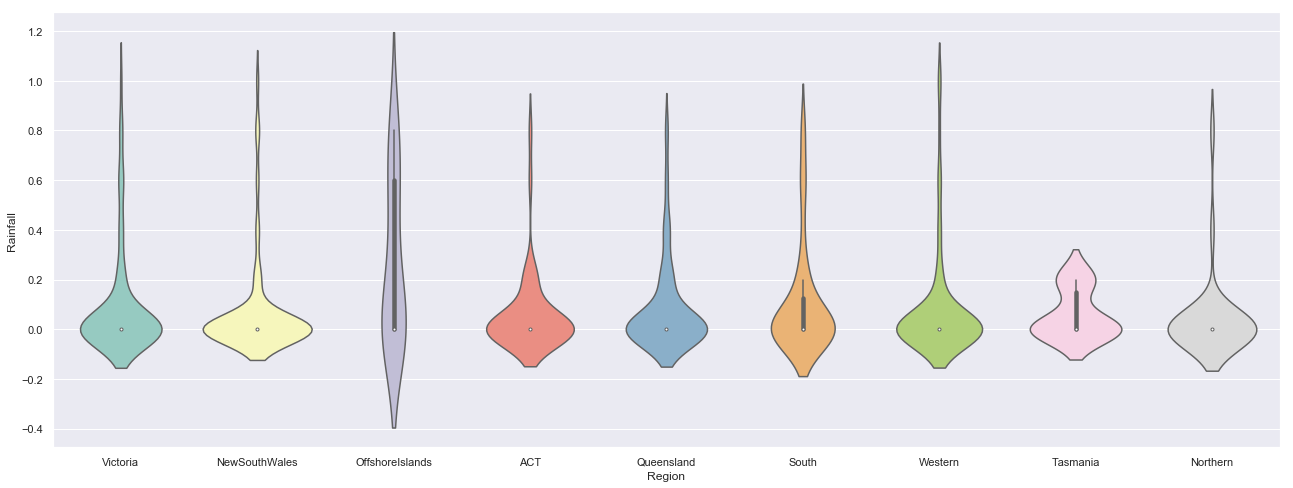

In [70]:
# distribución de predicciones si RainToday==No cuando no hay predicción para RainTomorrow
plt.figure(figsize=(22, 8));
sns.violinplot(x='Region', y='Rainfall', data=df_tomorrowNull.loc[df['RainToday']=='No',:], palette="Set3");

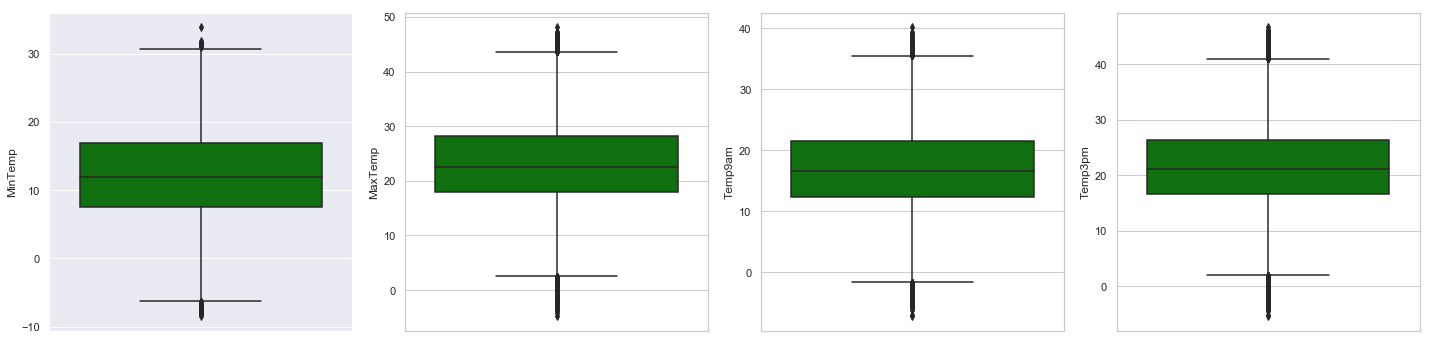

In [71]:
num_cols = 4
num_rows = len(num_1) - 1 / num_cols
plt.figure(figsize=(num_cols * 5, num_rows * 5))
for i in range(4):
    plt.subplot(num_rows + 1, num_cols, i + 1)
    sns.set_style('whitegrid')
    sns.boxplot(df[num_1[i]], color='green', orient='v')
    plt.tight_layout()

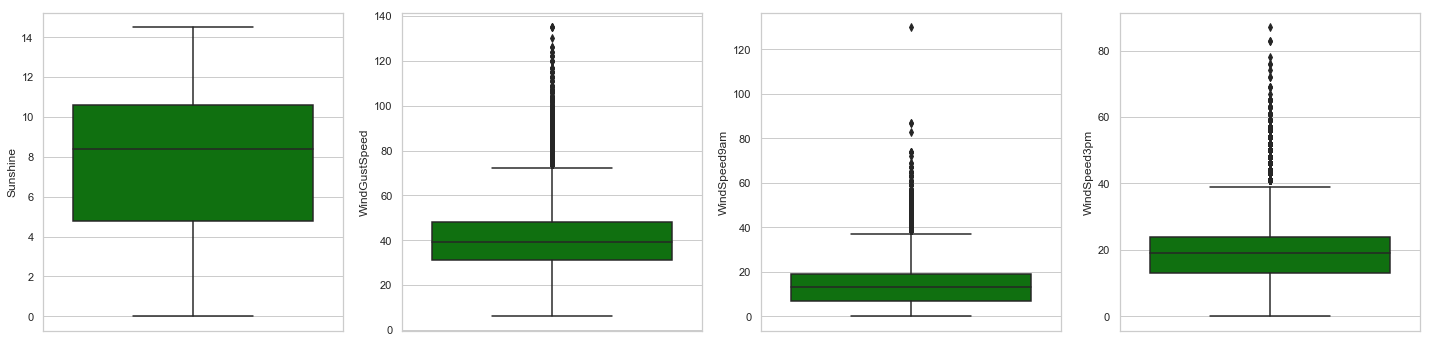

In [72]:
plt.figure(figsize=(num_cols * 5, num_rows * 5))
for i in range(4):
    plt.subplot(num_rows + 1, num_cols, i + 1)
    sns.set_style('whitegrid')
    sns.boxplot(df[num_2[i]], color='green', orient='v')
    plt.tight_layout()

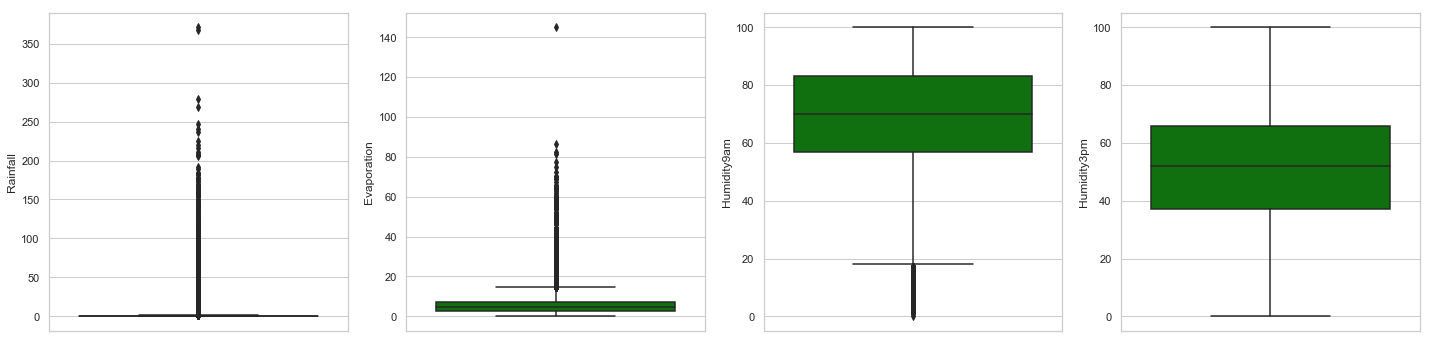

In [73]:
plt.figure(figsize=(num_cols * 5, num_rows * 5))
for i in range(4):
    plt.subplot(num_rows + 1, num_cols, i + 1)
    sns.set_style('whitegrid')
    sns.boxplot(df[num_3[i]], color='green', orient='v')
    plt.tight_layout()

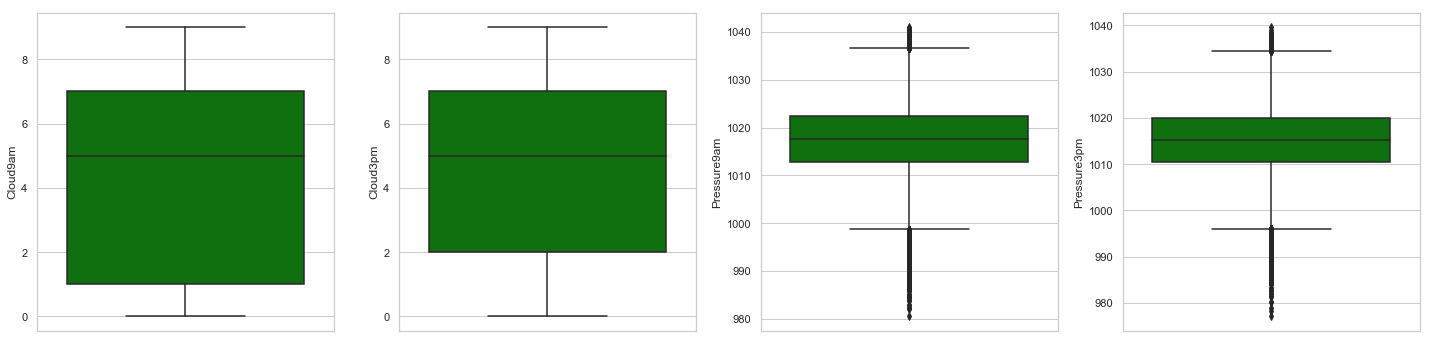

In [74]:
plt.figure(figsize=(num_cols * 5, num_rows * 5))
for i in range(4):
    plt.subplot(num_rows + 1, num_cols, i + 1)
    sns.set_style('whitegrid')
    sns.boxplot(df[num_4[i]], color='green', orient='v')
    plt.tight_layout()

#### Ploteo de variables continuas y tests asociados

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


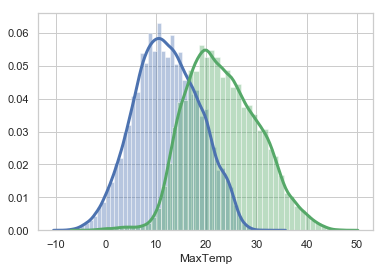

In [75]:
sns.distplot(df['MinTemp'], kde=True, bins=50, color = 'b', kde_kws={'linewidth': 3});
sns.distplot(df['MaxTemp'], kde=True, bins=50, color = 'g', kde_kws={'linewidth': 3});

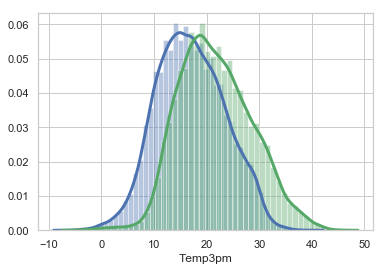

In [76]:
sns.distplot(df['Temp9am'], kde=True, bins=50, color = 'b', kde_kws={'linewidth': 3});
sns.distplot(df['Temp3pm'], kde=True, bins=50, color = 'g', kde_kws={'linewidth': 3});

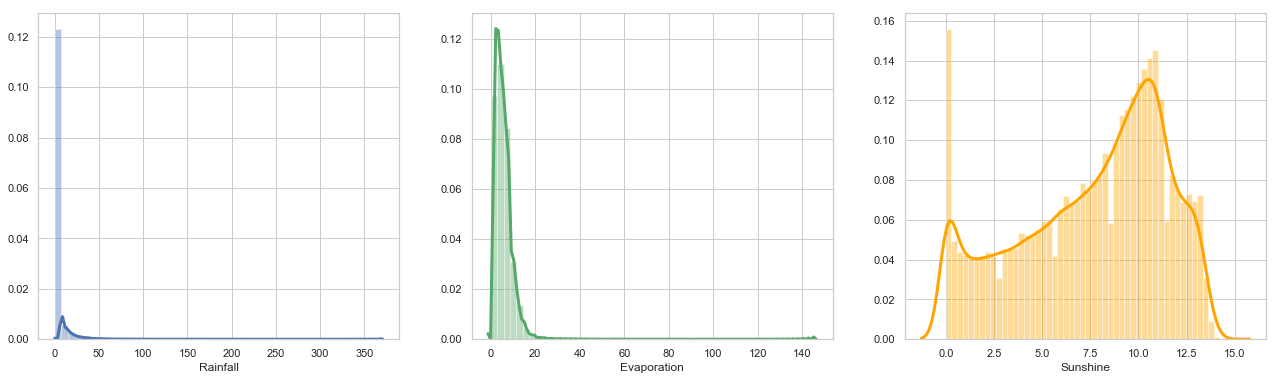

In [77]:
plt.figure(figsize=(22, 6));

plt.subplot(131)
sns.distplot(df['Rainfall'], kde=True, bins=50, color = 'b', kde_kws={'linewidth': 3});
plt.subplot(132)
sns.distplot(df['Evaporation'], kde=True, bins=50, color = 'g', kde_kws={'linewidth': 3});
plt.subplot(133)
sns.distplot(df['Sunshine'], kde=True, bins=50, color = 'orange', kde_kws={'linewidth': 3});

https://www.france24.com/es/asia-pac%C3%ADfico/20210322-las-peores-inundaciones-de-australia-en-d%C3%A9cadas-amenazan-con-agravarse

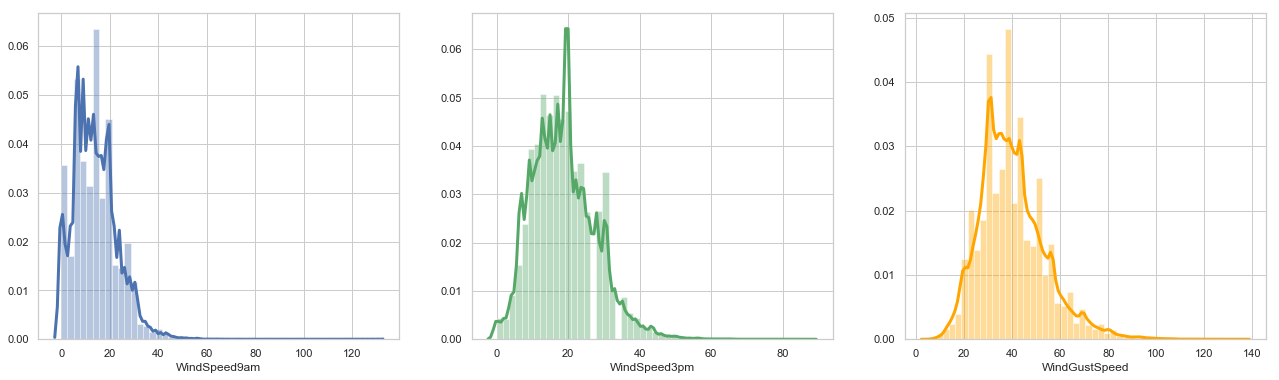

In [78]:
plt.figure(figsize=(22, 6));

plt.subplot(131)
sns.distplot(df['WindSpeed9am'], kde=True, bins=50, color = 'b', kde_kws={'linewidth': 3}); # link con advertencia web
plt.subplot(132)
sns.distplot(df['WindSpeed3pm'], kde=True, bins=50, color = 'g', kde_kws={'linewidth': 3});
plt.subplot(133)
sns.distplot(df['WindGustSpeed'], kde=True, bins=50, color = 'orange', kde_kws={'linewidth': 3});

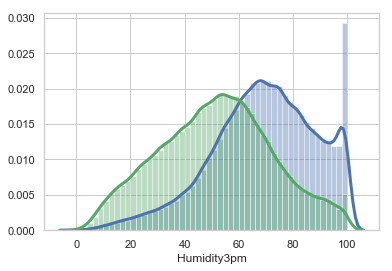

In [79]:
sns.distplot(df['Humidity9am'], kde=True, bins=50, color = 'b', kde_kws={'linewidth': 3});
sns.distplot(df['Humidity3pm'], kde=True, bins=50, color = 'g', kde_kws={'linewidth': 3});

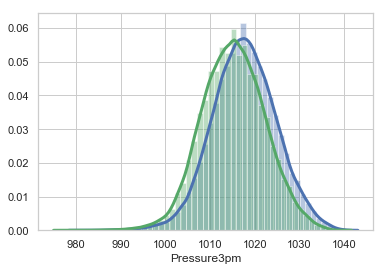

In [80]:
sns.distplot(df['Pressure9am'], kde=True, bins=50, color = 'b', kde_kws={'linewidth': 3});
sns.distplot(df['Pressure3pm'], kde=True, bins=50, color = 'g', kde_kws={'linewidth': 3});

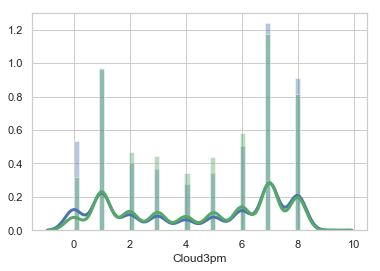

In [81]:
sns.distplot(df['Cloud9am'], kde=True, bins=50, color = 'b', kde_kws={'linewidth': 3});
sns.distplot(df['Cloud3pm'], kde=True, bins=50, color = 'g', kde_kws={'linewidth': 3});

Si bien varias series de datos manifiestan una distribución gausiana, no todos resisten el test de normalidad a medida que se verifican distintos testeos (resultados con transformaciones e imputaciones en secciones posteriores)

In [82]:
for i in numericas: 
    #st_test, pvalue = st.kstest(df.loc[df[i].notnull(), i], N=100, cdf='norm')
    st_test, pvalue = st.shapiro(df.loc[df[i].notnull(), i].sample(100, random_state=123))
    #st_test, pvalue = st.shapiro(df.loc[df[i].notnull(), i])

    alpha = 0.001 
   
    print(i, 'st_test:',st_test, ', pvalue = {:g}'.format(pvalue))
    if pvalue < alpha:  
        print('Rechazo H0')
    else:
        print('-----------Retengo H0') # H0: los datos provienen de una distribución normal

MinTemp st_test: 0.9911807179450989 , pvalue = 0.75921
-----------Retengo H0
MaxTemp st_test: 0.9757822155952454 , pvalue = 0.0621316
-----------Retengo H0
Rainfall st_test: 0.3149195909500122 , pvalue = 1.74675e-19
Rechazo H0
Evaporation st_test: 0.9465052485466003 , pvalue = 0.000491802
Rechazo H0
Sunshine st_test: 0.9317914843559265 , pvalue = 6.29845e-05
Rechazo H0
WindGustSpeed st_test: 0.9589020013809204 , pvalue = 0.00336051
-----------Retengo H0
WindSpeed9am st_test: 0.957888126373291 , pvalue = 0.00285118
-----------Retengo H0
WindSpeed3pm st_test: 0.9771844148635864 , pvalue = 0.0800388
-----------Retengo H0
Humidity9am st_test: 0.9696268439292908 , pvalue = 0.0206989
-----------Retengo H0
Humidity3pm st_test: 0.9909203052520752 , pvalue = 0.738653
-----------Retengo H0
Pressure9am st_test: 0.9839673638343811 , pvalue = 0.266927
-----------Retengo H0
Pressure3pm st_test: 0.9801570177078247 , pvalue = 0.136728
-----------Retengo H0
Temp9am st_test: 0.9896655082702637 , pvalue 

### 2. Limpieza y preparación de datos, ingeniería de features

#### Casteo, datos faltantes, valores extremos y atípicos, etc.

In [83]:
# casteo de variables de resultado para introducir en el modelo
df.loc[df['RainToday']=='Yes','RainToday']  = 1
df.loc[df['RainToday']=='No','RainToday']  = 0

df.loc[df['RainTomorrow']=='Yes','RainTomorrow']  = 1
df.loc[df['RainTomorrow']=='No','RainTomorrow']  = 0

df['RainToday'] = pd.to_numeric(df['RainToday'])
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'])

In [84]:
#df.columns

In [85]:
# reasignación según actualizaciones
numericas = numericas + ['RainToday', 'RainTomorrow', 'Year', 'Month', 'DayYear',
                         'DrySeason', 'DrySeasonExt', 'RainyDay']

In [86]:
categ = ['Location', 'WindGustDir', 'WindDir9am', 
         'WindDir3pm', 'Region']

Se desconocen los motivos por el cual se generaron los valores nulos o vacíos. Sobre la única variable que se registra posibilidad de error o acumulación de datos sin demasiado detalle es Rainfall. 

A la hora de considerar distintas alternativas de imputación y viendo los plots, resulta difícil encasillar inclemencias climáticas dentro de los límites del Q3+1.5IQR. 

En función de la información disponible y la generación de variables instrumentales, es posible generar estadísticos diarios controlados por las regiones de pertenencia o aquella más próxima a fin de generar cierta coherencia territorial y/o climática a partir de las variables de entorno.

In [87]:
n = 145460
summary = df.describe(percentiles=[.05, .1, .25, .5, .75, .9, .95, .99]).T
summary['cv'] = summary['std']/summary['mean']
summary['iqr'] = summary['75%'] - summary['25%']
summary['q1-1.5iqr'] = summary['25%'] - 1.5 * summary['iqr']
summary['q3+1.5iqr'] = summary['75%'] + 1.5 * summary['iqr']
summary['(q4-q3)/iqr'] = (summary['max'] - summary['75%'])/summary['iqr']
summary['missing'] = n - summary['count']
summary['missing%'] = round(summary['missing']/n*100,1)
summary.to_excel('summary2.xls')

In [88]:
summary.head(5)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max,cv,iqr,q1-1.5iqr,q3+1.5iqr,(q4-q3)/iqr,missing,missing%
MinTemp,143975.0,12.194034,6.398495,-8.5,1.8,4.0,7.6,12.0,16.9,20.8,23.0,25.8,33.9,0.524723,9.3,-6.35,30.85,1.827957,1485.0,1.0
MaxTemp,144199.0,23.221348,7.119049,-4.8,12.8,14.5,17.9,22.6,28.2,32.9,35.5,40.1,48.1,0.306573,10.3,2.45,43.65,1.932039,1261.0,0.9
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.0,0.0,0.8,6.2,13.0,37.4,371.0,3.591001,0.8,-1.20,2.00,462.750000,3261.0,2.2
Evaporation,82670.0,5.468232,4.193704,0.0,1.0,1.4,2.6,4.8,7.4,10.2,12.0,18.4,145.0,0.766921,4.8,-4.60,14.60,28.666667,62790.0,43.2
Sunshine,75625.0,7.611178,3.785483,0.0,0.3,1.5,4.8,8.4,10.6,12.1,12.8,13.4,14.5,0.497358,5.8,-3.90,19.30,0.672414,69835.0,48.0


In [89]:
median = df.groupby(['Date','Region']).median()
median.to_excel('median2.xls')
# considero ACT como NSW porque está allí contenido

In [90]:
# integro ACT a New South Wales para el cálculo de área dado que una gran parte de missing values residen allí
df.loc[(df['Location']=='Canberra') | (df['Location']=='Tuggeranong'), 'Region'] = 'NewSouthWales' 

In [91]:
# imputación por mediana según Date & Region
# variables numéricas (de entrada o info primaria),
# se excluyen las de resultado (RainToday, RainTomorrow) y las generadas en este TP

var_imput = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
                  'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 
                  'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am','Temp3pm']

df_imput = df.join(median[var_imput], on=['Date','Region'], rsuffix='_med')

In [92]:
#MCAR o MAR
for i in var_imput:
    df_imput.loc[df_imput[i].isnull(), i] = df_imput.loc[df_imput[i].isnull(), i+'_med']

In [93]:
# subset del df con datos imputados
dff = df_imput[df.columns]

In [94]:
# revierto transformación anterior: ACT se vuelve a renombrar como tal (New South Wales)
dff.loc[(dff['Location']=='Canberra') | (dff['Location']=='Tuggeranong'), 'Region'] = 'ACT'

# corrijo valores de nuevos al contar con más datos en Rainfall (los sumo a RainyDay, no en RainToday)
dff.loc[dff['Rainfall']>1, 'RainyDay'] = 1
dff.loc[dff['Rainfall']<=1, 'RainyDay'] = 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [95]:
n = 145460
summary_imput = dff.describe(percentiles=[.05, .1, .25, .5, .75, .9, .95, .99]).T
summary_imput['cv'] = summary_imput['std']/summary_imput['mean']
summary_imput['iqr'] = summary_imput['75%'] - summary_imput['25%']
summary_imput['q1-1.5iqr'] = summary_imput['25%'] - 1.5 * summary_imput['iqr']
summary_imput['q3+1.5iqr'] = summary_imput['75%'] + 1.5 * summary_imput['iqr']
summary_imput['(q4-q3)/iqr'] = (summary_imput['max'] - summary_imput['75%'])/summary_imput['iqr']
summary_imput['missing'] = n - summary_imput['count']
summary_imput['missing%'] = round(summary_imput['missing']/n*100,1)
summary_imput.to_excel('summary_imput2.xls')

In [96]:
summary_imput.head(5)

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max,cv,iqr,q1-1.5iqr,q3+1.5iqr,(q4-q3)/iqr,missing,missing%
MinTemp,145457.0,12.196651,6.388728,-8.5,1.8,4.0,7.6,12.0,16.8,20.8,23.0,25.7,33.9,0.523810,9.2,-6.20,30.60,1.858696,3.0,0.0
MaxTemp,145449.0,23.224516,7.115092,-4.8,12.9,14.5,17.9,22.6,28.2,32.9,35.5,40.1,48.1,0.306361,10.3,2.45,43.65,1.932039,11.0,0.0
Rainfall,145396.0,2.344779,8.410974,0.0,0.0,0.0,0.0,0.0,0.8,6.0,13.0,37.2,371.0,3.587107,0.8,-1.20,2.00,462.750000,64.0,0.0
Evaporation,145055.0,5.383224,3.749565,0.0,1.0,1.6,2.8,4.8,7.4,9.8,11.6,16.0,145.0,0.696528,4.6,-4.10,14.30,29.913043,405.0,0.3
Sunshine,144853.0,7.608156,3.696874,0.0,0.4,1.7,5.0,8.4,10.5,12.0,12.7,13.3,14.5,0.485909,5.5,-3.25,18.75,0.727273,607.0,0.4


In [97]:
#Dado que los datos provienen de observaciones de la naturaleza,
#resulta difícil invisibilizar la presencia de eventos extremos tales como tormentas severas en Rainfall
#A su vez, se advierte que en algunos casos los datos pluviométricos pueden no llegar y acumularse,
#distorisonando el monitoreo

#los valores sobresalientes se concentran en Rainfall y en Evaporation
#tras análisis, se detecta que varias de las variables rondan en una relación (máximo-q3)/iqr = 2
#se aplica dicho cálculo q3 + iqr * 2
rainfall_max = 0.8 + 0.8 * 2 # la relación (máximo-q3)/iqr era de 462.750000 veces
rainfall_max2 = 0.8 + 0.8 * 9.25 
#en este caso se vincula con la posibilidad de eventos extremos,
#tomando la relación con la velocidad de la mayor ráfagas de viento
rainfall_99 = 37.2 # representa un décimo del máximo registrado

evaporation_max = 7.4 + 4.6 * 2 # la relación máximo/iqr era de 29.913043 veces
evaporation_99 = 16

print(rainfall_max)
print(rainfall_max2) 
print(evaporation_max) # se verifica que es mayor al valor del percentil 99

2.4000000000000004
8.200000000000001
16.6


In [98]:
dff.loc[dff['Rainfall']>=rainfall_99, 'Rainfall'] = 37.2
dff.loc[dff['Evaporation']>=evaporation_max, 'Evaporation'] = 16.6

#### Transformaciones, tests de independencia, normalidad, etc.

In [99]:
# correlación lineal
#plt.figure(figsize=(12, 12));
#sns.heatmap(dff.corr('spearman'), annot=True,fmt='.1g');

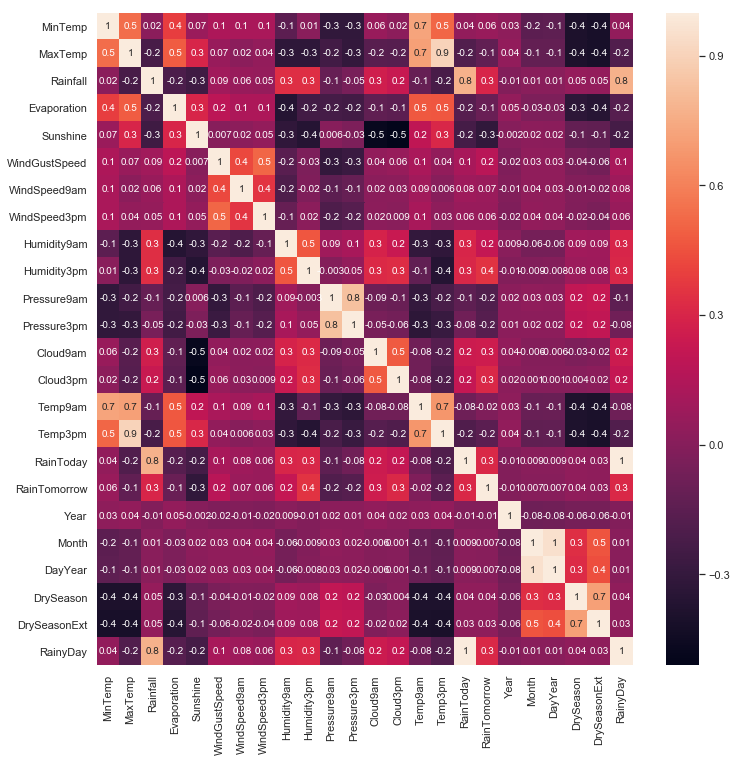

In [100]:
# correlación lineal
plt.figure(figsize=(12, 12));
sns.heatmap(dff.corr('kendall'), annot=True,fmt='.1g');

En línea con los indicios iniciales, nubosidad, humedad y precipitaciones son las variables que se destacan por correlacionar positivamente con RainTomorrow. Asimismo, evaporación, horas de sol y temperatura máxima, correlacionan negativamente.

A partir de este insight es posible identificar que la lista de variables candidatas para estimar RainTomorrow son:
* Rainfall, Sunshine, Humidity3pm, Cloud9am, Cloud3pm
Es necesario seleccionar una de las siguientes duplas:
* RainToday o RainyToday (con imputaciones)
* DrySeason o DrySeasonExtendida (relación muy baja, evaluar omisión)
* Pressure9am o Pressure3pm
Las destinadas a ser omitidas son:
* Year, Month, DayYear (presentan una relación muy baja, hay otras manifestación de las características del tiempo)
* Temp9am (es redundante, resulta mejor predictor del día siguiente la atmósfera de la tarde)
A ser evaluadas:
* 'MinTemp', 'MaxTemp', 'Temp3pm'
* 'Evaporation', 'Humidity9am', 
* 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm'
Con este último grupo se observa una relación débil pero se desconoce su significancia.

Dado que se advierte no normalidad en las variables (aún cuando atraviesan por transformacones) se opta por los test no paramétricos: Spearman (rank, rho) y Kendall (tau) por sobre el de Pearson (r). El test de Spearman, en comparación con el de Pearson, asigna pesos altos a relaciones monotónicas por más que sean no lineales, priorizando ciertos rasgos de los datos más que sus valores per se. También son menos sensibles a valores extremos o atípicos. Por su parte, el tau de Kendall suele ser más estable (también suele ser utilizado con muestras pequeñas por su bondad del ajuste). Se distingue que una correlación significativa no necesariamente coincide con un valor elevado del coeficiente.

In [101]:
logdf = dff[numericas].applymap(lambda x: np.log(x) if x!=0 else 0)
#cubodf = dff[numericas].applymap(lambda x: x**3)
#cuadradodf = dff[numericas].applymap(lambda x: x**2)
#invdf = dff[numericas].applymap(lambda x: 1/x if x!=0 else 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [102]:
# testeo para las transformaciones logarítmicas de las variables corregidas (imputaciones, valores extremos)
for i in numericas: 
    st_test, pvalue = st.shapiro(logdf.loc[logdf[i].notnull(), i].sample(100, random_state=123))
    alpha = 0.001 
   
    print(i, 'st_test:',st_test, ', pvalue = {:g}'.format(pvalue))
    if pvalue < alpha:  
        print('Rechazo H0')
    else:
        print('-----------Retengo H0') # H0: los datos provienen de una distribución normal

MinTemp st_test: 0.9342778325080872 , pvalue = 8.77725e-05
Rechazo H0
MaxTemp st_test: 0.9794954061508179 , pvalue = 0.121423
-----------Retengo H0
Rainfall st_test: 0.7788138389587402 , pvalue = 5.81898e-11
Rechazo H0
Evaporation st_test: 0.9223600625991821 , pvalue = 1.88193e-05
Rechazo H0
Sunshine st_test: 0.7018108367919922 , pvalue = 5.94423e-13
Rechazo H0
WindGustSpeed st_test: 0.9576482772827148 , pvalue = 0.00274299
-----------Retengo H0
WindSpeed9am st_test: 0.9202884435653687 , pvalue = 1.45798e-05
Rechazo H0
WindSpeed3pm st_test: 0.9508246779441833 , pvalue = 0.000940493
Rechazo H0
Humidity9am st_test: 0.9259836673736572 , pvalue = 2.96616e-05
Rechazo H0
Humidity3pm st_test: 0.9162063002586365 , pvalue = 8.90457e-06
Rechazo H0
Pressure9am st_test: 0.9888566732406616 , pvalue = 0.573339
-----------Retengo H0
Pressure3pm st_test: 0.9832983613014221 , pvalue = 0.237979
-----------Retengo H0
Temp9am st_test: 0.8701459169387817 , pvalue = 7.10584e-08
Rechazo H0
Temp3pm st_test: 0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1306: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1306: UserWarnin

In [103]:
# dff acumula imputación de datos faltantes, tratamiento de outliers y trasnformaciones logarítmicas sobre variables numéricas
dff = dff.join(logdf, rsuffix='_log')
#.join(cubodf, rsuffix='_cubo').join(cuadradodf, rsuffix='_log').join(invdf, rsuffix='_inv')

In [104]:
# correlación lineal
#plt.figure(figsize=(48, 48));
#sns.heatmap(dff.corr('kendall'), annot=True, fmt='.1g');

In [105]:
date + categ

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Region']

In [106]:
# re testeo para las variables originales corregidas (imputaciones, valores extremos)
for i in numericas: 
    st_test, pvalue = st.shapiro(dff.loc[dff[i].notnull(), i].sample(100, random_state=123))
    alpha = 0.001 
   
    print(i, 'st_test:',st_test, ', pvalue = {:g}'.format(pvalue))
    if pvalue < alpha:  
        print('Rechazo H0')
    else:
        print('-----------Retengo H0') # H0: los datos provienen de una distribución normal

MinTemp st_test: 0.9892550706863403 , pvalue = 0.604742
-----------Retengo H0
MaxTemp st_test: 0.9923400282859802 , pvalue = 0.84528
-----------Retengo H0
Rainfall st_test: 0.4422612190246582 , pvalue = 9.83533e-18
Rechazo H0
Evaporation st_test: 0.945493757724762 , pvalue = 0.000423851
Rechazo H0
Sunshine st_test: 0.9598243236541748 , pvalue = 0.00390696
-----------Retengo H0
WindGustSpeed st_test: 0.9804075360298157 , pvalue = 0.142996
-----------Retengo H0
WindSpeed9am st_test: 0.9495730400085449 , pvalue = 0.000777648
Rechazo H0
WindSpeed3pm st_test: 0.9652165174484253 , pvalue = 0.00963419
-----------Retengo H0
Humidity9am st_test: 0.974064290523529 , pvalue = 0.0455946
-----------Retengo H0
Humidity3pm st_test: 0.9882222414016724 , pvalue = 0.524737
-----------Retengo H0
Pressure9am st_test: 0.9880551099777222 , pvalue = 0.51228
-----------Retengo H0
Pressure3pm st_test: 0.9838053584098816 , pvalue = 0.259647
-----------Retengo H0
Temp9am st_test: 0.9898662567138672 , pvalue = 0.

#### Subsetting, DropNaNs & Dummies

In [107]:
x = dff.sort_values(['Date', 'Location', 'Region'])
x.groupby(['Region', 'Location']).first().to_excel('firstDayWithData2.xls')
# convalido en fecha de inicio 01/01/09
# se suman 3 locaciones a posteriores (01/03/2013)
# Katherine y Uluru, de Northern
# Nhil, Victori

In [108]:
x.groupby(['Region', 'Location']).last().to_excel('lastDayWithData2.xls')
# convalido en fecha de inicio 25/06/17

In [109]:
#selecciono datos con mayor representación 
#dff = dff.loc[dff['Year'] >= 2009, :]
#dff.shape

In [110]:
dff['Region'].value_counts(dropna=False)

NewSouthWales      39569
Victoria           34954
Western            24276
Queensland         12313
Northern            9389
South               9242
ACT                 6475
Tasmania            6233
OffshoreIslands     3009
Name: Region, dtype: int64

In [111]:
# sobre la varible TimeStamp se hicieron distintas codificaciones y derivaciones al inicio
# sobre las categóricas dicotómicas, se realizó una codificación manual y se corrigieron valores de RainToday tras la imputación de Rainfall
# sobre las variables categóricas aún no transformadas, se obtienen dummies, análogas a OneHotEcoding

dummies_loc = pd.get_dummies(dff['Location'], prefix='Loc', prefix_sep='_', dummy_na=False,
                             columns=None, sparse=False, drop_first=False, dtype=None)

dummies_reg = pd.get_dummies(dff['Region'], prefix='Reg', prefix_sep='_', dummy_na=False,
                             columns=None, sparse=False, drop_first=False, dtype=None)

dummies_wgd = pd.get_dummies(dff['WindGustDir'], prefix='wgd', prefix_sep='_', dummy_na=False,
                             columns=None, sparse=False, drop_first=False, dtype=None)

dummies_wd9 = pd.get_dummies(dff['WindDir9am'], prefix='wd9', prefix_sep='_', dummy_na=False,
                             columns=None, sparse=False, drop_first=False, dtype=None)

dummies_wd3 = pd.get_dummies(dff['WindDir3pm'], prefix='wd3', prefix_sep='_', dummy_na=False,
                             columns=None, sparse=False, drop_first=False, dtype=None)

In [112]:
# a los procesos contemprados en dff se adiconan las dummies recién generadas
# dff acumulaba la imputación de datos faltantes, tratamiento de outliers y trasnformaciones logarítmicas sobre variables numéricas
ensamble = dff.join(dummies_loc).join(dummies_reg).join(dummies_wgd).join(dummies_wd9).join(dummies_wd3)

In [113]:
#list(ensamble.columns)

In [114]:
ensamble.shape, ensamble.dropna().shape

((145460, 160), (118262, 160))

In [115]:
ensamble_wt_nan = ensamble.dropna().copy()

In [116]:
x = ensamble_wt_nan.drop(columns=['Date', 'Location', 'Region', 
                                  'WindGustDir', 'WindDir9am', 'WindDir3pm',
                                  'RainTomorrow'])
y = ensamble_wt_nan['RainTomorrow']

In [117]:
x['RainyDay'].value_counts(normalize=True)

0.0    0.774441
1.0    0.225559
Name: RainyDay, dtype: float64

In [118]:
x.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118262 entries, 0 to 145458
Columns: 153 entries, MinTemp to wd3_WSW
dtypes: float64(42), int64(5), uint8(106)
memory usage: 55.3 MB


### 3. Esquema de validación de resultados, entrenamiento y evaluación de modelos

#### Preprocessing, Feature importance & Scaling

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.metrics import confusion_matrix, classification_report

In [120]:
#split training & test
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.30, 
                                                    random_state = 456, shuffle=True)
print('Train:', x_train.shape, y_train.shape)
print('Test:', x_test.shape, y_test.shape)

Train: (82783, 153) (82783,)
Test: (35479, 153) (35479,)


In [121]:
# feature importance
def select_features_anova(x_train, y_train, x_test, k= 'all'):  
    fs = SelectKBest(score_func=f_classif, k=k )  
    fs.fit(x_train, y_train)  
    x_train_fs = fs.transform(x_train)
    x_test_fs = fs.transform(x_test)
    return x_train_fs, x_test_fs, fs

def select_features_mi(x_train, y_train, x_test, k= 'all'):  
    fs = SelectKBest(score_func=mutual_info_classif, k=k )  
    fs.fit(x_train, y_train)  
    x_train_fs = fs.transform(x_train)  
    x_test_fs = fs.transform(x_test)
    return x_train_fs, x_test_fs, fs

x_train_anova, x_test_anova, anova = select_features_anova(x_train, y_train, x_test)
x_train_mi, x_test_mi, mi = select_features_mi(x_train, y_train, x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [39 40 44 45 46 48 71] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [122]:
features = pd.DataFrame(columns= x.columns, index=['anova', 'mutual_info'],
                        data=[anova.scores_, mi.scores_]).T

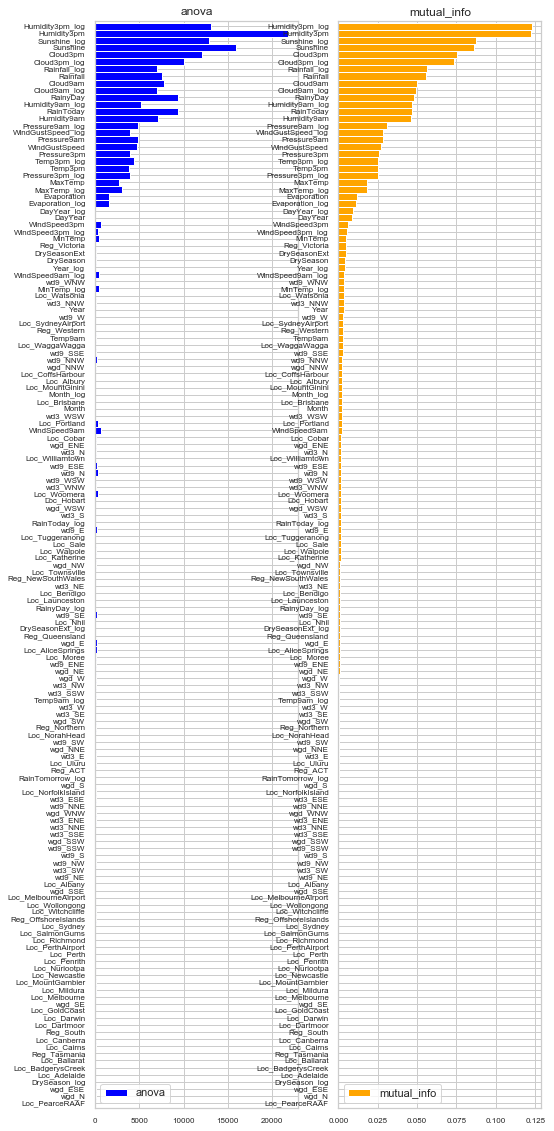

In [123]:
features.sort_values(by='mutual_info', ascending=True).plot.barh(rot=0,
                                                                 subplots=True, sharex=False,
                                                                 figsize=(8, 20), layout=(1,2),
                                                                 stacked=True, align='center', 
                                                                 fontsize=8, width=1, color=['blue', 'orange']);

In [124]:
features.sort_values(by='mutual_info', ascending=True).to_excel('features2.xls')

In [125]:
# estandarización por feature o columna
# por default toma media y desvío de cada columna
scaler = StandardScaler().fit(x_train)
x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

minmax = MinMaxScaler().fit(x_train)
x_train_mm = minmax.transform(x_train)
x_test_mm = minmax.transform(x_test)

norm = Normalizer().fit(x_train)
x_train_norm = norm.transform(x_train)
x_test_norm = norm.transform(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [150]:
data_mutual_info =  features.loc[features['mutual_info'].sort_values(ascending=False)>=0.003, 'mutual_info'].index
#data_mutual_info

In [151]:
#features['mutual_info'].sort_values(ascending=False)[:20]
#features.loc[features['mutual_info'].sort_values(ascending=False)>=0.003, 'mutual_info']

In [128]:
data_anova =  features.loc[features['anova'].sort_values(ascending=False)>=300, 'anova'].index
#data_anova

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp3pm', 'RainToday', 'RainyDay', 'MinTemp_log', 'MaxTemp_log',
       'Rainfall_log', 'Evaporation_log', 'Sunshine_log', 'WindGustSpeed_log',
       'WindSpeed9am_log', 'WindSpeed3pm_log', 'Humidity9am_log',
       'Humidity3pm_log', 'Pressure9am_log', 'Pressure3pm_log', 'Temp3pm_log',
       'Cloud9am_log', 'Cloud3pm_log', 'Loc_Woomera', 'wd9_N'],
      dtype='object')

In [129]:
features['anova'].sort_values(ascending=False)[:20]

Humidity3pm        21814.790921
Sunshine           15975.745439
Humidity3pm_log    13051.088760
Sunshine_log       12823.978562
Cloud3pm           12078.668843
Cloud3pm_log       10072.606693
RainToday           9319.869820
RainyDay            9319.869820
Cloud9am            7849.316788
Rainfall            7548.798827
Humidity9am         7119.038076
Cloud9am_log        6973.150354
Rainfall_log        6971.482944
Humidity9am_log     5205.155475
Pressure9am_log     4873.098826
Pressure9am         4854.618199
WindGustSpeed       4789.213308
Temp3pm_log         4375.676798
Pressure3pm_log     4011.784446
Pressure3pm         3993.929812
Name: anova, dtype: float64

#### Modelos, sets alternativos y evaluación de resultados

In [130]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform',  p=2, metric='minkowski')

knnL1 = KNeighborsClassifier(n_neighbors=5, weights='distance',  p=1, metric='minkowski')

log = LogisticRegression(C=1.0, 
                         random_state=123, solver='lbfgs', penalty='l2', max_iter=500)

logWd = LogisticRegression(C=1.0, class_weight='balanced', 
                         random_state=123, solver='lbfgs', penalty='l2', max_iter=500)

logL1 = LogisticRegression(C=1.6, class_weight={1:.5}, 
                         random_state=123, solver='saga', penalty='l1', max_iter=500) # scaler

rf = RandomForestClassifier(n_estimators=50, criterion='gini', 
                            bootstrap=True, random_state=123, class_weight={1:.5}) # entropy & info gain

ada = AdaBoostClassifier(n_estimators=50, algorithm='SAMME.R', random_state=123) # SAMME

In [131]:
models = [knn, knnL1, log, logWd, logL1, rf, ada]
labels = ['knn', 'knnL1', 'log', 'logWd', 'logl1', 'rf', 'ada']
df_rainTomorrow = pd.DataFrame(y_test)
df_rainTomorrow.columns = ['y_test']

In [132]:
# alternativas de datos
data_train = [x_train, x_train_st, x_train_mm, x_train_norm] 
data_test = [x_test, x_test_st, x_test_mm, x_test_norm]

#data_mutual_info
#data_anova

In [133]:
y_train.value_counts()

0.0    64297
1.0    18486
Name: RainTomorrow, dtype: int64

In [134]:
y_test.value_counts()

0.0    27647
1.0     7832
Name: RainTomorrow, dtype: int64

El problema de clasificación es binario, las métricas relevantes para la evaluación son las siguientes:

- **Precision**: $\frac{TP}{TP+FP}$. Se relaciona con una baja tasa de falsos positivos.
- **Recall**: $\frac{TP}{TP+FN}$. Mide la cantidad de predicciones correctas para cada clase. 
- **F1-score**: Promedio entre Precision y Recall. $2\frac{Recall x Precision}{Recall + Precision}$. Este indicador es preferible al accuracy cuando se trata de clases desbalanceadas y no se aplica resampleo uniforme a fin de comparar modelos.
- **Matriz de Confusión - MC:**: es una forma de visualizar para cada clase TP,TN,FP y FN.

Siendo:
- TP (True Positives): casos de lluvia identificados como lluvia (cuadrante inferior derecho de la MC).
- TN (True Negatives): casos de no lluvia identificados como no lluvia (cuadrante superior izquierdo de la MC).
- FP (False Positives): casos de no lluvia identificados como lluvia (cuadrante superior derecho de la MC).
- FN (False Negatives): casos de lluvia identificados como no lluvia (cuadrante inferior izquierdo de la MC).

No obstante, se utilizará AUC como la métrica principal y la que utilizará la función objetivo de las librerías de búsqueda bayesiana.

In [135]:
for i,j in zip(models, labels):
    df_rainTomorrow['y_'+j] = i.fit(x_train, y_train).predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


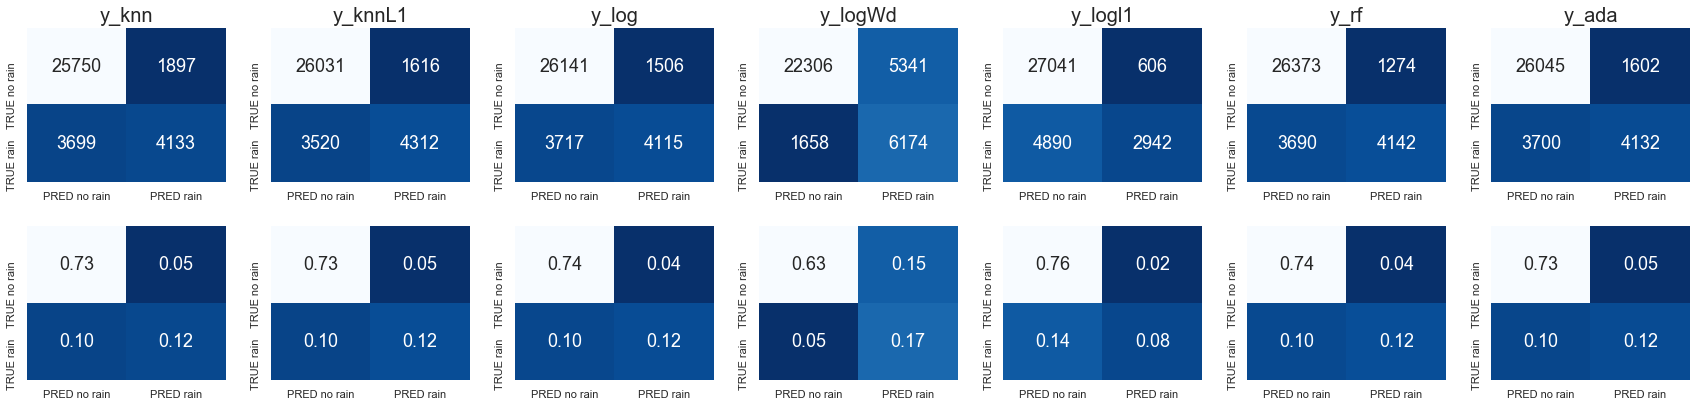

In [136]:
plt.figure(figsize=(24, 6))
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 18})

for i,j in zip(range(1,8), df_rainTomorrow.columns[1:]):
        plt.subplot(2, 7, i)
        sns.heatmap(confusion_matrix(y_test, df_rainTomorrow[j]), annot=True,  fmt='.0f', cbar=False,
                    xticklabels=['PRED no rain', 'PRED rain'], 
                    yticklabels=['TRUE no rain', 'TRUE rain'], cmap=plt.cm.Blues_r)
        plt.title(j, fontsize=20)
        plt.subplot(2, 7, 7+i)
        sns.heatmap(confusion_matrix(y_test, df_rainTomorrow[j])/y_test.shape[0], annot=True,  fmt='.2f', cbar=False,
                    xticklabels=['PRED no rain', 'PRED rain'], 
                    yticklabels=['TRUE no rain', 'TRUE rain'], cmap=plt.cm.Blues_r)
        plt.tight_layout()

In [140]:
for j in df_rainTomorrow.columns[1:]:
    print(j, classification_report(y_test, df_rainTomorrow[j]))

y_knn               precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     27647
         1.0       0.69      0.53      0.60      7832

   micro avg       0.84      0.84      0.84     35479
   macro avg       0.78      0.73      0.75     35479
weighted avg       0.83      0.84      0.83     35479

y_knnL1               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     27647
         1.0       0.73      0.55      0.63      7832

   micro avg       0.86      0.86      0.86     35479
   macro avg       0.80      0.75      0.77     35479
weighted avg       0.85      0.86      0.85     35479

y_log               precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     27647
         1.0       0.73      0.53      0.61      7832

   micro avg       0.85      0.85      0.85     35479
   macro avg       0.80      0.74      0.76     35479
weighted avg       0.84      0.85      0.84     35479


In [141]:
# data_mutual_info
for i,j in zip(models, labels):
    df_rainTomorrow['MIy_'+j] = i.fit(x_train[data_mutual_info], y_train).predict(x_test[data_mutual_info])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


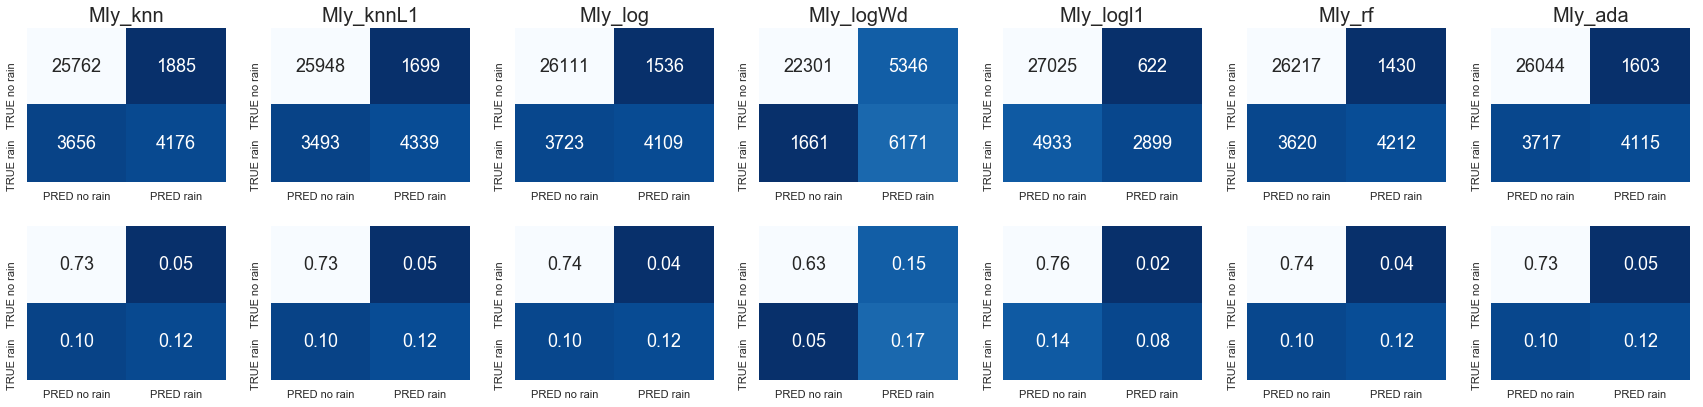

In [142]:
plt.figure(figsize=(24, 6))
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 18})

for i,j in zip(range(1,8), df_rainTomorrow.columns[8:]):
        plt.subplot(2, 7, i)
        sns.heatmap(confusion_matrix(y_test, df_rainTomorrow[j]), annot=True,  fmt='.0f', cbar=False,
                    xticklabels=['PRED no rain', 'PRED rain'], 
                    yticklabels=['TRUE no rain', 'TRUE rain'], cmap=plt.cm.Blues_r)
        plt.title(j, fontsize=20)
        plt.subplot(2, 7, 7+i)
        sns.heatmap(confusion_matrix(y_test, df_rainTomorrow[j])/y_test.shape[0], annot=True,  fmt='.2f', cbar=False,
                    xticklabels=['PRED no rain', 'PRED rain'], 
                    yticklabels=['TRUE no rain', 'TRUE rain'], cmap=plt.cm.Blues_r)
        plt.tight_layout()

In [143]:
for j in df_rainTomorrow.columns[8:]:
    print(j, classification_report(y_test, df_rainTomorrow[j]))

MIy_knn               precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     27647
         1.0       0.69      0.53      0.60      7832

   micro avg       0.84      0.84      0.84     35479
   macro avg       0.78      0.73      0.75     35479
weighted avg       0.83      0.84      0.84     35479

MIy_knnL1               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     27647
         1.0       0.72      0.55      0.63      7832

   micro avg       0.85      0.85      0.85     35479
   macro avg       0.80      0.75      0.77     35479
weighted avg       0.85      0.85      0.85     35479

MIy_log               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     27647
         1.0       0.73      0.52      0.61      7832

   micro avg       0.85      0.85      0.85     35479
   macro avg       0.80      0.73      0.76     35479
weighted avg       0.84      0.85      0.84     

In [144]:
# data_anova
for i,j in zip(models, labels):
    df_rainTomorrow['Ay_'+j] = i.fit(x_train[data_anova], y_train).predict(x_test[data_anova])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


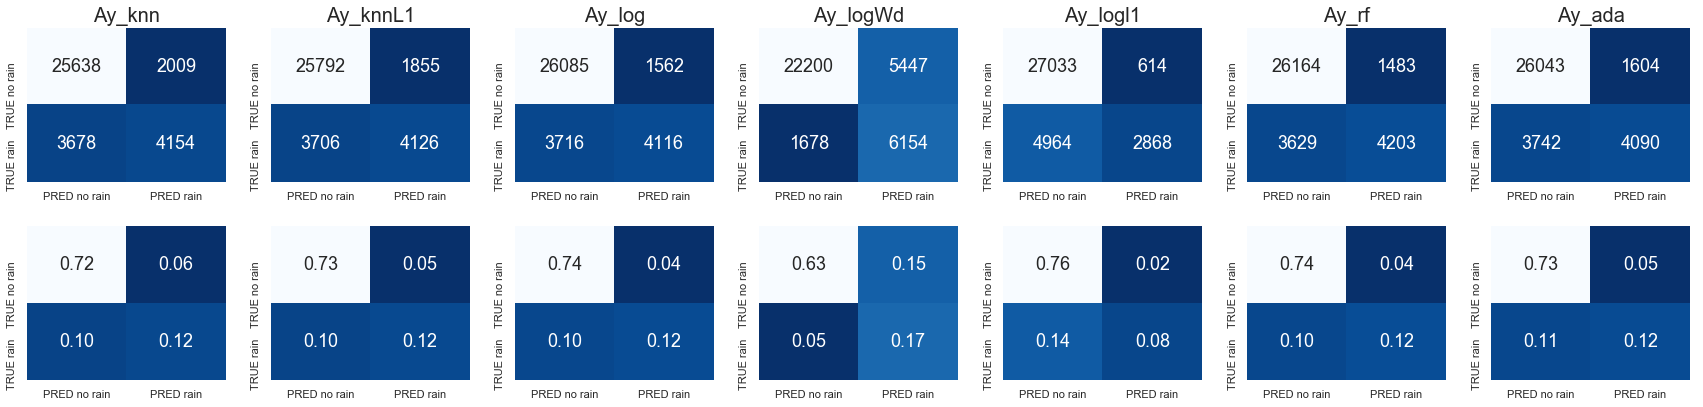

In [145]:
plt.figure(figsize=(24, 6))
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 18})

for i,j in zip(range(1,8), df_rainTomorrow.columns[15:]):
        plt.subplot(2, 7, i)
        sns.heatmap(confusion_matrix(y_test, df_rainTomorrow[j]), annot=True,  fmt='.0f', cbar=False,
                    xticklabels=['PRED no rain', 'PRED rain'], 
                    yticklabels=['TRUE no rain', 'TRUE rain'], cmap=plt.cm.Blues_r)
        plt.title(j, fontsize=20)
        plt.subplot(2, 7, 7+i)
        sns.heatmap(confusion_matrix(y_test, df_rainTomorrow[j])/y_test.shape[0], annot=True,  fmt='.2f', cbar=False,
                    xticklabels=['PRED no rain', 'PRED rain'], 
                    yticklabels=['TRUE no rain', 'TRUE rain'], cmap=plt.cm.Blues_r)
        plt.tight_layout()

In [146]:
for j in df_rainTomorrow.columns[15:]:
    print(j, classification_report(y_test, df_rainTomorrow[j]))

Ay_knn               precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     27647
         1.0       0.67      0.53      0.59      7832

   micro avg       0.84      0.84      0.84     35479
   macro avg       0.77      0.73      0.75     35479
weighted avg       0.83      0.84      0.83     35479

Ay_knnL1               precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     27647
         1.0       0.69      0.53      0.60      7832

   micro avg       0.84      0.84      0.84     35479
   macro avg       0.78      0.73      0.75     35479
weighted avg       0.83      0.84      0.84     35479

Ay_log               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     27647
         1.0       0.72      0.53      0.61      7832

   micro avg       0.85      0.85      0.85     35479
   macro avg       0.80      0.73      0.76     35479
weighted avg       0.84      0.85      0.84     354

In [147]:
# StandarScaler transformation
for i,j in zip(models, labels):
    df_rainTomorrow['sty_'+j] = i.fit(x_train_st, y_train).predict(x_test_st)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


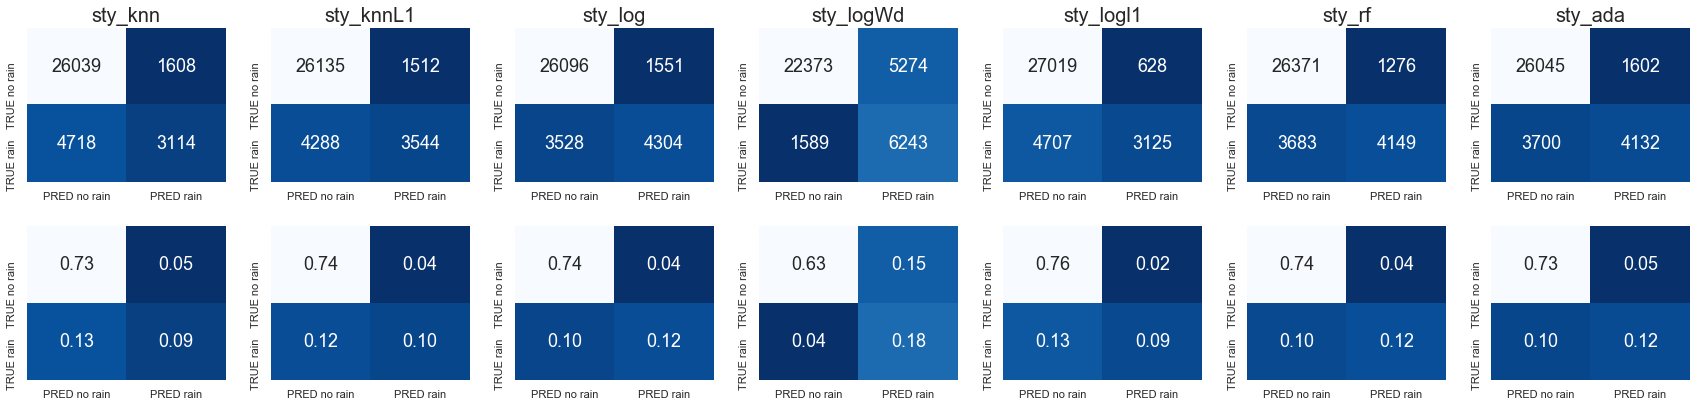

In [148]:
plt.figure(figsize=(24, 6))
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 18})

for i,j in zip(range(1,8), df_rainTomorrow.columns[22:]):
        plt.subplot(2, 7, i)
        sns.heatmap(confusion_matrix(y_test, df_rainTomorrow[j]), annot=True,  fmt='.0f', cbar=False,
                    xticklabels=['PRED no rain', 'PRED rain'], 
                    yticklabels=['TRUE no rain', 'TRUE rain'], cmap=plt.cm.Blues_r)
        plt.title(j, fontsize=20)
        plt.subplot(2, 7, 7+i)
        sns.heatmap(confusion_matrix(y_test, df_rainTomorrow[j])/y_test.shape[0], annot=True,  fmt='.2f', cbar=False,
                    xticklabels=['PRED no rain', 'PRED rain'], 
                    yticklabels=['TRUE no rain', 'TRUE rain'], cmap=plt.cm.Blues_r)
        plt.tight_layout()

In [149]:
for j in df_rainTomorrow.columns[22:]:
    print(j, classification_report(y_test, df_rainTomorrow[j]))

sty_knn               precision    recall  f1-score   support

         0.0       0.85      0.94      0.89     27647
         1.0       0.66      0.40      0.50      7832

   micro avg       0.82      0.82      0.82     35479
   macro avg       0.75      0.67      0.69     35479
weighted avg       0.81      0.82      0.80     35479

sty_knnL1               precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     27647
         1.0       0.70      0.45      0.55      7832

   micro avg       0.84      0.84      0.84     35479
   macro avg       0.78      0.70      0.73     35479
weighted avg       0.82      0.84      0.82     35479

sty_log               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     27647
         1.0       0.74      0.55      0.63      7832

   micro avg       0.86      0.86      0.86     35479
   macro avg       0.81      0.75      0.77     35479
weighted avg       0.85      0.86      0.85     

## Próximos pasos
* Revisar instancias del preprocesamiento (IQR difiere por región, los días de lluvia, en NSW Q4=41 y Northern Q4>60)
* Explorar hiperparámetros alternativos
* Incorporar curva ROC y AUC en el análisis de los resultados